Библиотеки

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.stats import ttest_1samp
from statsmodels.graphics.tsaplots import plot_acf
import itertools
import requests
import optuna
import logging
import warnings
# import shap
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)
warnings.simplefilter("ignore")
logger = logging.getLogger("optuna")
logger.setLevel(logging.WARNING)

/Users/mreshetnev/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Подключение к API MOEX

In [2]:
# API parameters
engine = 'stock'
market = 'shares'
board = 'TQBR'
start_date = '2022-04-01'
end_date = str(datetime.today() - pd.Timedelta('1 day'))[:10]

# Composition of the IMOEX according to https://sbercib.ru/publication/birzhevye-indeksy-mosbirzhi
tickers = [
    'AFKS', 'AFLT', 'ALRS',
     'BSPB', 'CBOM', 'CHMF', 'ENPG', 'FEES',
    'FLOT', 'GAZP', 'GMKN', 'HYDR', 'IRAO', 'LKOH', 'MAGN',
    'MGNT', 'MOEX', 'MSNG', 'MTLR', 'MTLRP', 'MTSS', 'NLMK', 'NVTK', 'PHOR',
    'PIKK', 'PLZL', 'POSI', 'ROSN', 'RTKM', 'RUAL', 'SBER', 'SBERP', 'SELG',
    'SMLT', 'SNGS', 'SNGSP', 'T', 'TATN', 'TATNP', 'TRNFP', 
    'UPRO', 'VKCO', 'VTBR', 'YDEX', 
    'YNDX', 'TCSG'
    # 'HEAD', 'UGLD', 'SVCB', 'ASTR', 'LEAS',
]

# Function to parse the data
def fetch_data(ticker):
    url = f"https://iss.moex.com/iss/history/engines/{engine}/markets/{market}/boards/{board}/securities/{ticker}.json"
    all_data = []
    start = 0

    expected_columns = ['SECID', 'TRADEDATE', 'WAPRICE', 'OPEN', 'CLOSE', 'LOW', 'HIGH', 'VOLUME']

    while True:
        params = {
            'from': start_date,
            'till': end_date,
            'start': start
        }
        response = requests.get(url, params=params)
        if response.status_code != 200:
            print(f"Failed to fetch data for {ticker}: {response.status_code}")
            break

        json_data = response.json()
        history = json_data.get('history', {})
        data = history.get('data', [])
        columns = history.get('columns', [])

        if not data:
            break

        df = pd.DataFrame(data, columns=columns)

        df = df.reindex(columns=expected_columns).dropna(how='all')

        if not df.empty:
            all_data.append(df)
            start += len(data)
        else:
            break

    if all_data:

        dtypes = {
            'SECID': 'str',
            'TRADEDATE': 'str',
            'WAPRICE': 'float64',
            'OPEN': 'float64',
            'CLOSE': 'float64',
            'LOW': 'float64',
            'HIGH': 'float64',
            'VOLUME': 'int64'
        }
        return pd.concat(all_data, ignore_index=True).astype(dtypes)
    else:
        return pd.DataFrame()

results = {}
for ticker in tqdm(tickers):
    data = fetch_data(ticker)
    if not data.empty:
        results[ticker] = data
     

100%|██████████| 46/46 [00:33<00:00,  1.39it/s]


### Перевод в pd.DataFrame

In [3]:
data_to_pd = []
for name in results.keys():
    data_to_pd.append(results[name])

data = pd.concat([df for df in data_to_pd])

print(f'data.shape = {data.shape}')
print(f'columns = {data.columns}')

data.shape = (34894, 8)
columns = Index(['SECID', 'TRADEDATE', 'WAPRICE', 'OPEN', 'CLOSE', 'LOW', 'HIGH',
       'VOLUME'],
      dtype='object')


### Сохраняем сырой DataFrame в CSV

In [4]:
data.to_csv('raw_data.csv', index=False)

### Приводим к одному индексу

In [5]:
full_idxs = data['TRADEDATE'].unique()
df = pd.DataFrame(data=full_idxs,
                  columns=['TRADEDATE'])

tickers_series = pd.Series(tickers, name='SECID')

df = df.merge(tickers_series, how='cross')

df = df.merge(data, 
              how='left', 
              left_on=['TRADEDATE', 'SECID'], 
              right_on=['TRADEDATE', 'SECID']).sort_values(by=['SECID', 'TRADEDATE'])

df['TRADEDATE'] = pd.to_datetime(df['TRADEDATE'], format='%Y-%m-%d')

df.set_index('TRADEDATE', inplace=True)

df

,SECID,WAPRICE,OPEN,CLOSE,LOW,HIGH,VOLUME
TRADEDATE,,,,,,,
2022-04-01,AFKS,14.473,14.380,13.890,13.890,14.880,59304300.0
2022-04-04,AFKS,14.105,14.057,14.105,13.501,14.499,40030900.0
2022-04-05,AFKS,13.606,14.200,13.451,12.756,14.272,25206000.0
2022-04-06,AFKS,13.474,13.160,13.493,12.856,13.923,14170100.0
2022-04-07,AFKS,13.699,13.300,13.622,13.273,14.095,15927000.0
...,...,...,...,...,...,...,...
2025-05-12,YNDX,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-13,YNDX,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-14,YNDX,NaN,NaN,NaN,NaN,NaN,NaN


### Проверка данных

In [6]:
df

,SECID,WAPRICE,OPEN,CLOSE,LOW,HIGH,VOLUME
TRADEDATE,,,,,,,
2022-04-01,AFKS,14.473,14.380,13.890,13.890,14.880,59304300.0
2022-04-04,AFKS,14.105,14.057,14.105,13.501,14.499,40030900.0
2022-04-05,AFKS,13.606,14.200,13.451,12.756,14.272,25206000.0
2022-04-06,AFKS,13.474,13.160,13.493,12.856,13.923,14170100.0
2022-04-07,AFKS,13.699,13.300,13.622,13.273,14.095,15927000.0
...,...,...,...,...,...,...,...
2025-05-12,YNDX,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-13,YNDX,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-14,YNDX,NaN,NaN,NaN,NaN,NaN,NaN


#### Пропуски

In [7]:
list_of_tickers_with_gaps = df.groupby('SECID')['WAPRICE'].apply(lambda x: x.isna().sum()).sort_values(ascending=False)
list_of_tickers_with_gaps

SECID
T        676
YDEX     585
YNDX     235
TCSG     136
VKCO      23
FEES      12
GMKN       4
TRNFP      4
PLZL       3
VTBR       2
TATNP      0
TATN       0
PIKK       0
UPRO       0
SNGS       0
SMLT       0
SELG       0
SBERP      0
SBER       0
RUAL       0
RTKM       0
ROSN       0
POSI       0
SNGSP      0
AFKS       0
AFLT       0
IRAO       0
ALRS       0
BSPB       0
CBOM       0
CHMF       0
ENPG       0
FLOT       0
GAZP       0
HYDR       0
LKOH       0
NVTK       0
MAGN       0
MGNT       0
MOEX       0
MSNG       0
MTLR       0
MTLRP      0
MTSS       0
NLMK       0
PHOR       0
Name: WAPRICE, dtype: int64

**Решение:**

- Т-Банк менял тикер с TCSG на T. Соединим данные по этим тикерам
- Яндекс менял тикер с YNDX на YDEX. Соединим данные по этим тикерам

Недавно допущены к торгам: 
- LEAS
- HEAD 
- SVCB
- LEAS 

Пока для простоты их отбросим. В будущей версии сервиса научимся их обрабатывать.



##### Объединяем котировки для разных тикеров Яндекса и Т

In [8]:
def merge_series(df, prev_ticket, cur_ticket):
    """
    Объединяет два pd.Series, заполняя NaN значения из другой Series.
    
    Parameters:
    -----------
    prev_series : pd.Series
        Первая Series с индексом 'TRADEDATE'
    cur_series : pd.Series
        Вторая Series с индексом 'TRADEDATE'
    
    Returns:
    --------
    pd.Series
        Объединенная Series, где NaN значения заполнены из другой Series,
        если в другой Series по той же дате есть не-NaN значение.
    """
    prev_series = df.loc[df['SECID'] == prev_ticket]
    cur_series = df.loc[df['SECID'] == cur_ticket]
    
    # Создаем объединенный индекс, чтобы включить все возможные даты из обеих Series
    combined_index = prev_series.index.union(cur_series.index)
    
    # Переиндексируем обе Series для использования общего индекса
    prev_reindexed = prev_series.reindex(combined_index)
    cur_reindexed = cur_series.reindex(combined_index)
    
    # Создаем результирующую Series, где значения берутся из prev_series,
    # а если там NaN, то из cur_series
    result = cur_reindexed.fillna(prev_reindexed)
    
    return result


def merge_series_in_df(df, prev_ticket, cur_ticket):
    df_copy = df.copy()
    merged_series = merge_series(df, prev_ticket, cur_ticket)

    df_copy = df_copy[~( (df['SECID'] == prev_ticket) | (df['SECID'] == cur_ticket) )]
    
    df_copy = pd.concat([df_copy, merge_series(df, prev_ticket, cur_ticket)])
    
    return df_copy

In [9]:
# Яндекс
df = merge_series_in_df(df, 'YNDX', 'YDEX')

# ТБанк
df = merge_series_in_df(df, 'TCSG', 'T')

Проверяем новые пропуски

In [10]:
list_of_tickers_with_gaps = df.groupby('SECID')['WAPRICE'].apply(lambda x: x.isna().sum()).sort_values(ascending=False) 
list_of_tickers_with_gaps

SECID
YDEX     27
VKCO     23
T        19
FEES     12
TRNFP     4
GMKN      4
PLZL      3
VTBR      2
SBERP     0
POSI      0
ROSN      0
RTKM      0
RUAL      0
SBER      0
SNGSP     0
SELG      0
SMLT      0
SNGS      0
PHOR      0
TATN      0
TATNP     0
UPRO      0
PIKK      0
AFKS      0
AFLT      0
NLMK      0
ALRS      0
BSPB      0
CBOM      0
CHMF      0
ENPG      0
FLOT      0
GAZP      0
HYDR      0
IRAO      0
LKOH      0
MAGN      0
MGNT      0
MOEX      0
MSNG      0
MTLR      0
MTLRP     0
MTSS      0
NVTK      0
Name: WAPRICE, dtype: int64

##### Заполняем пропуски

Смотрим на котировки с пропусками

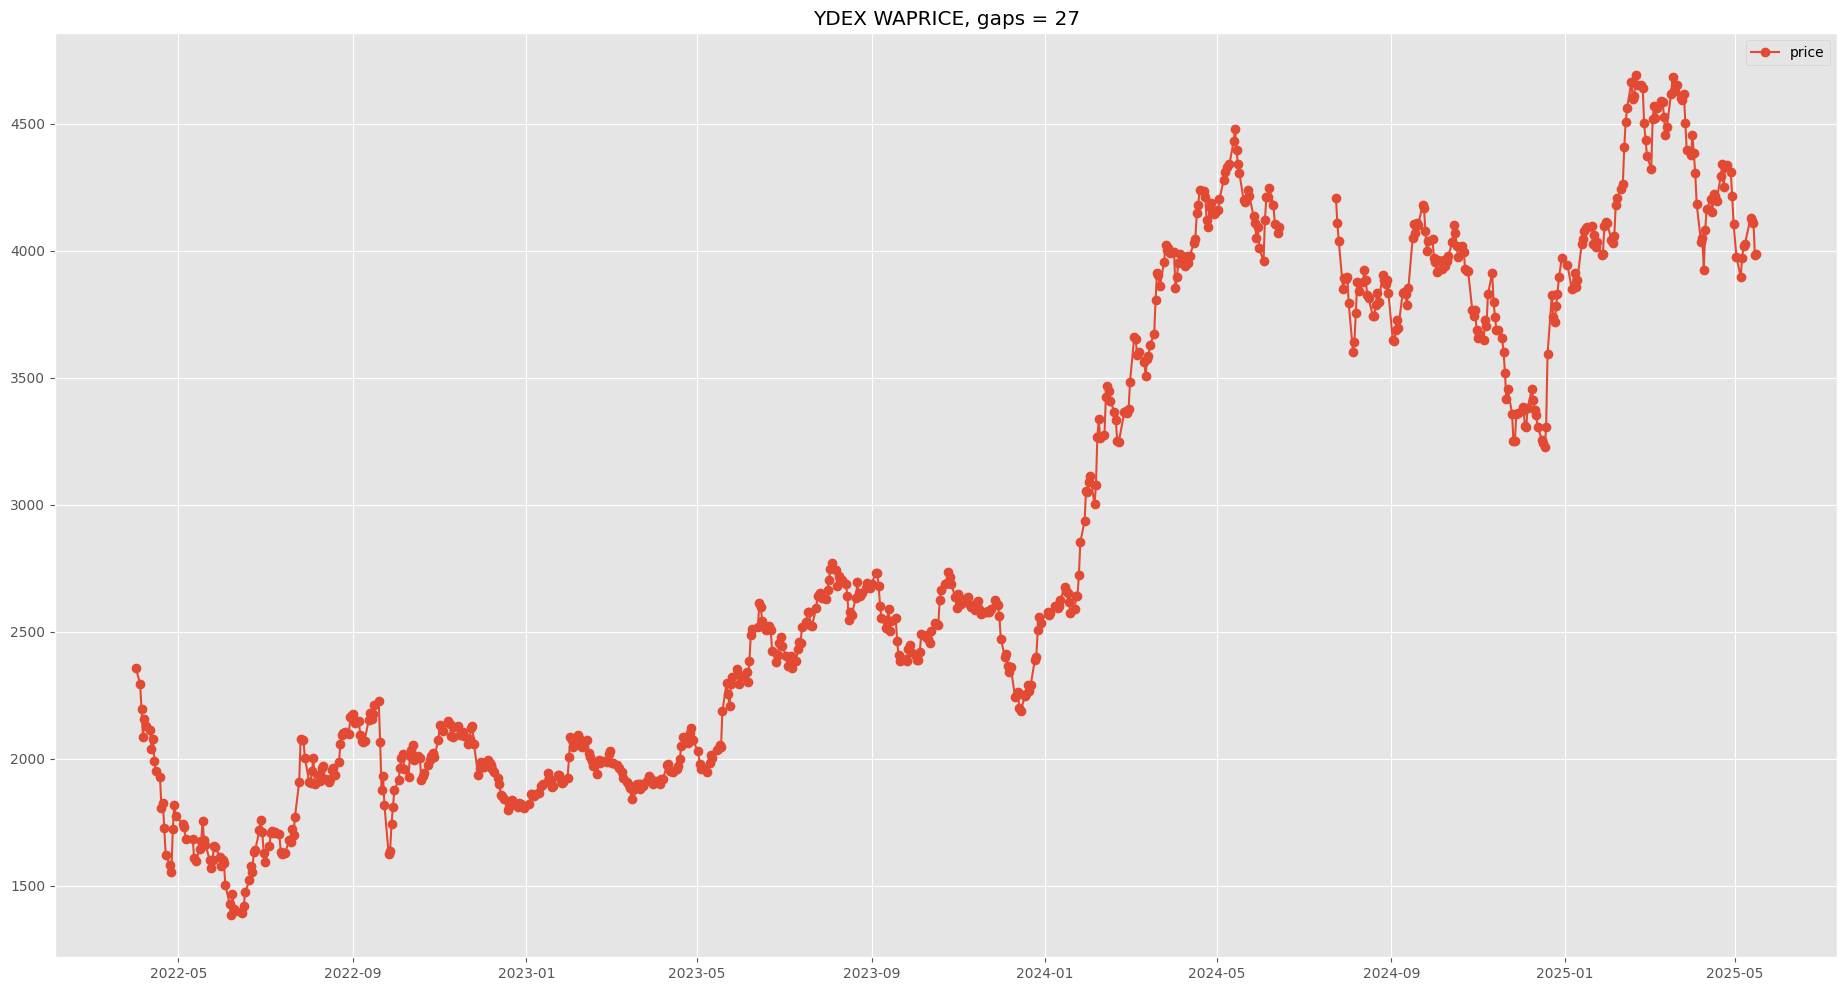

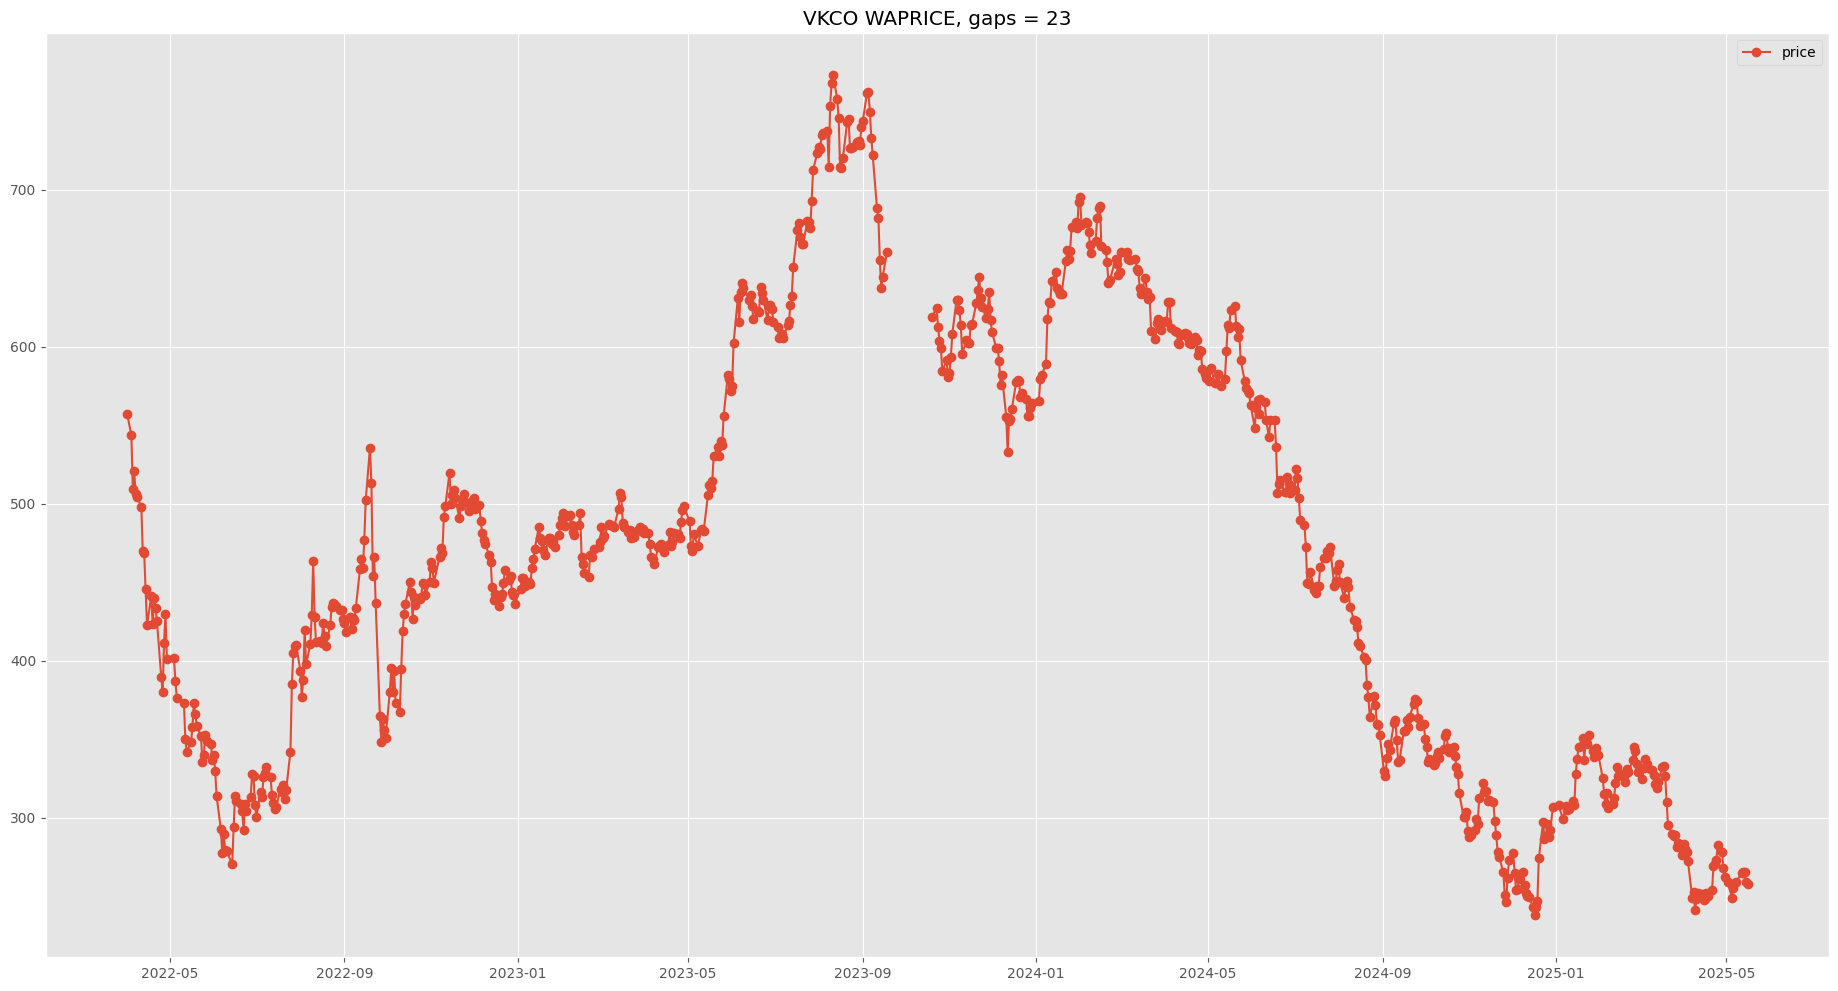

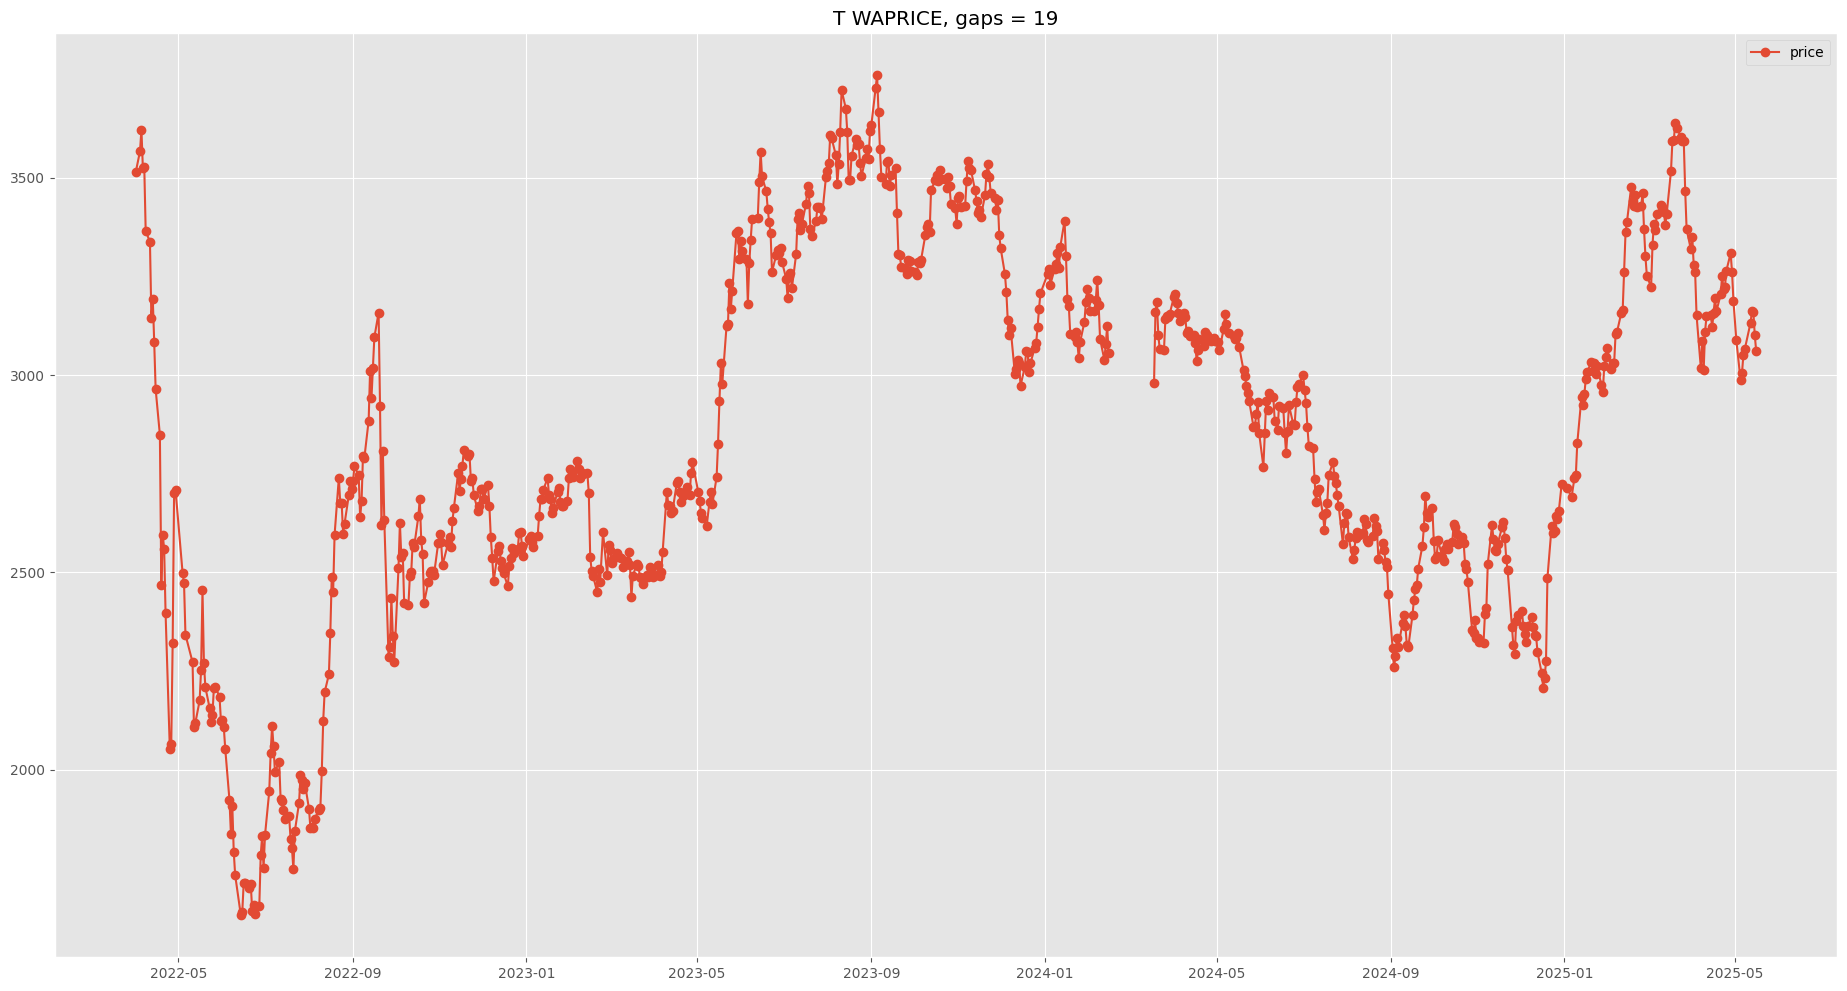

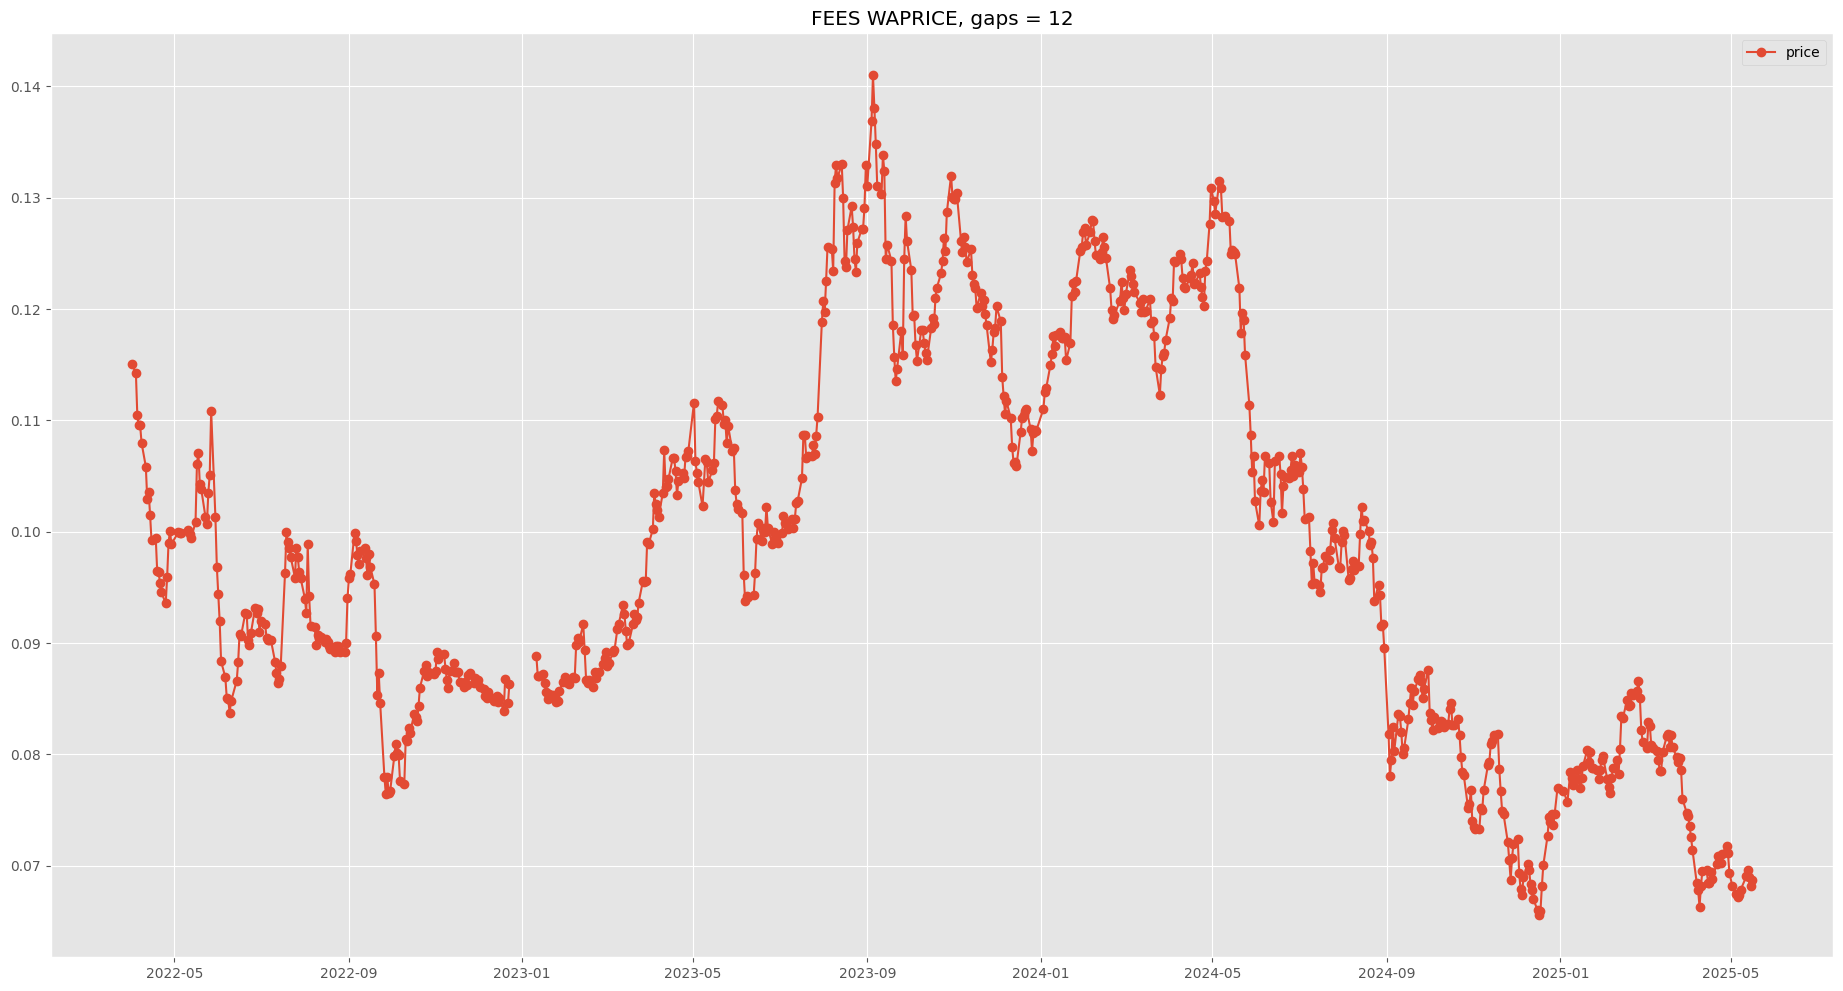

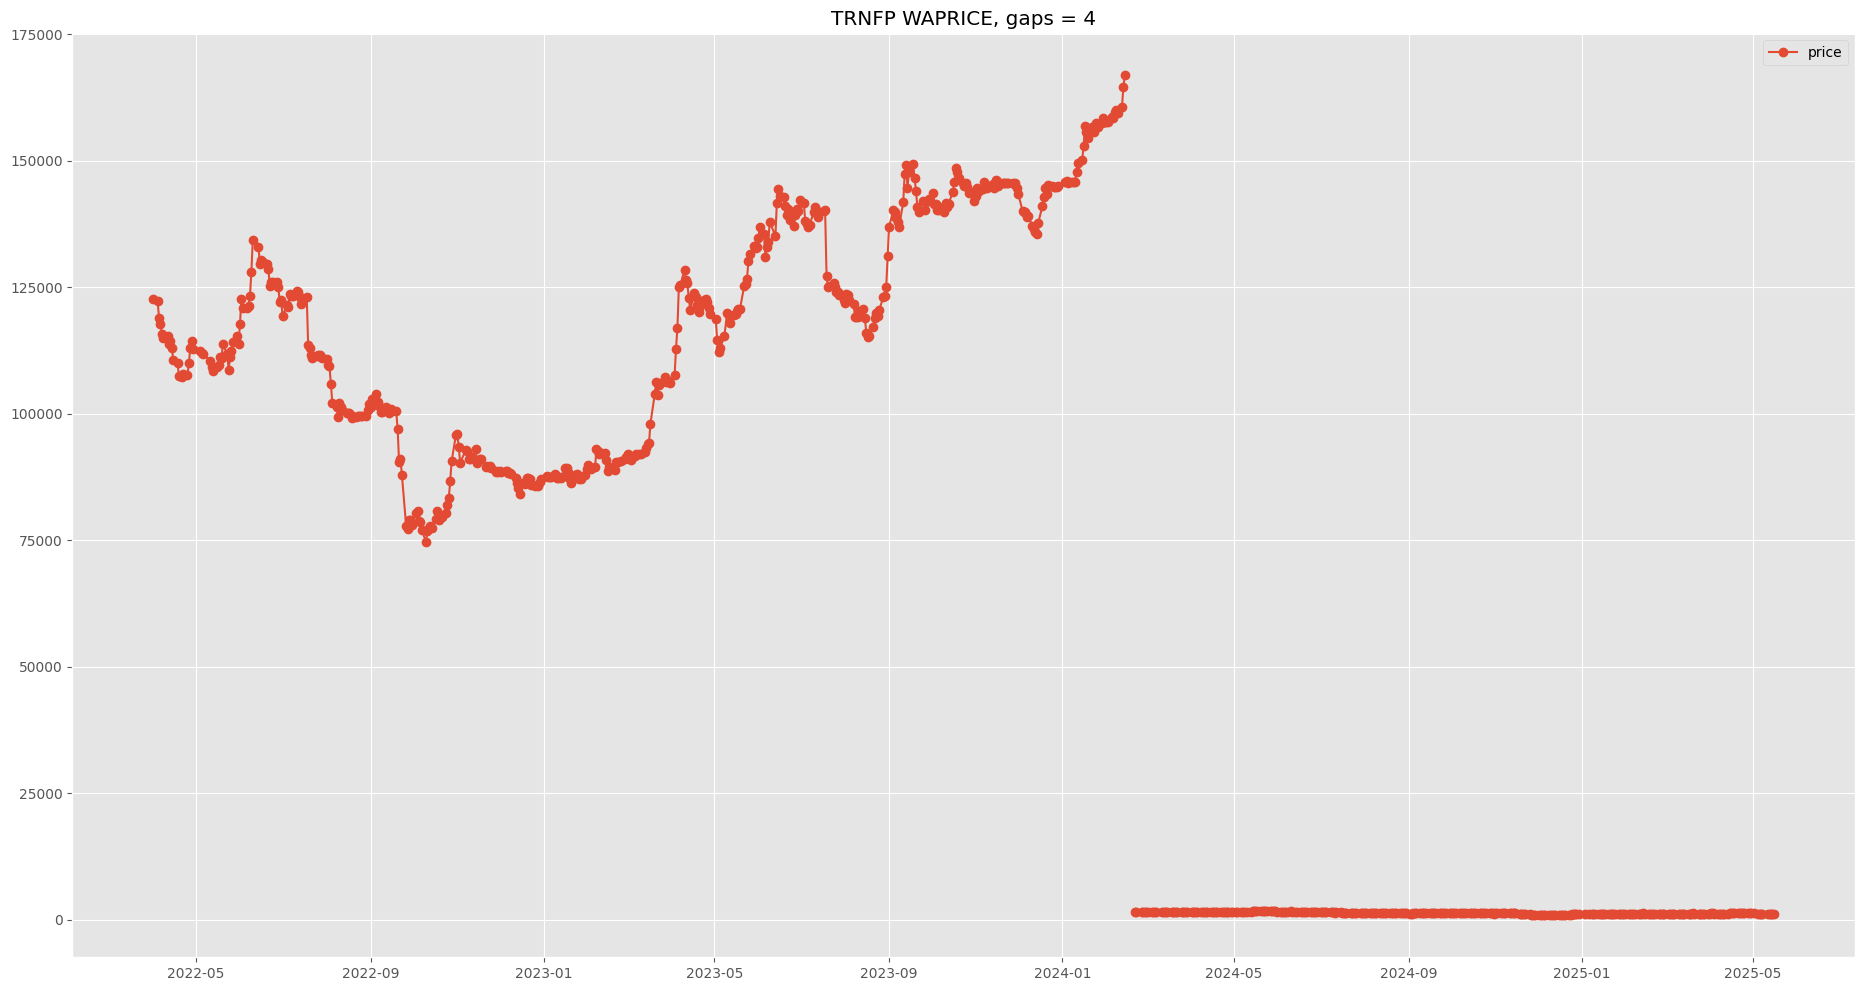

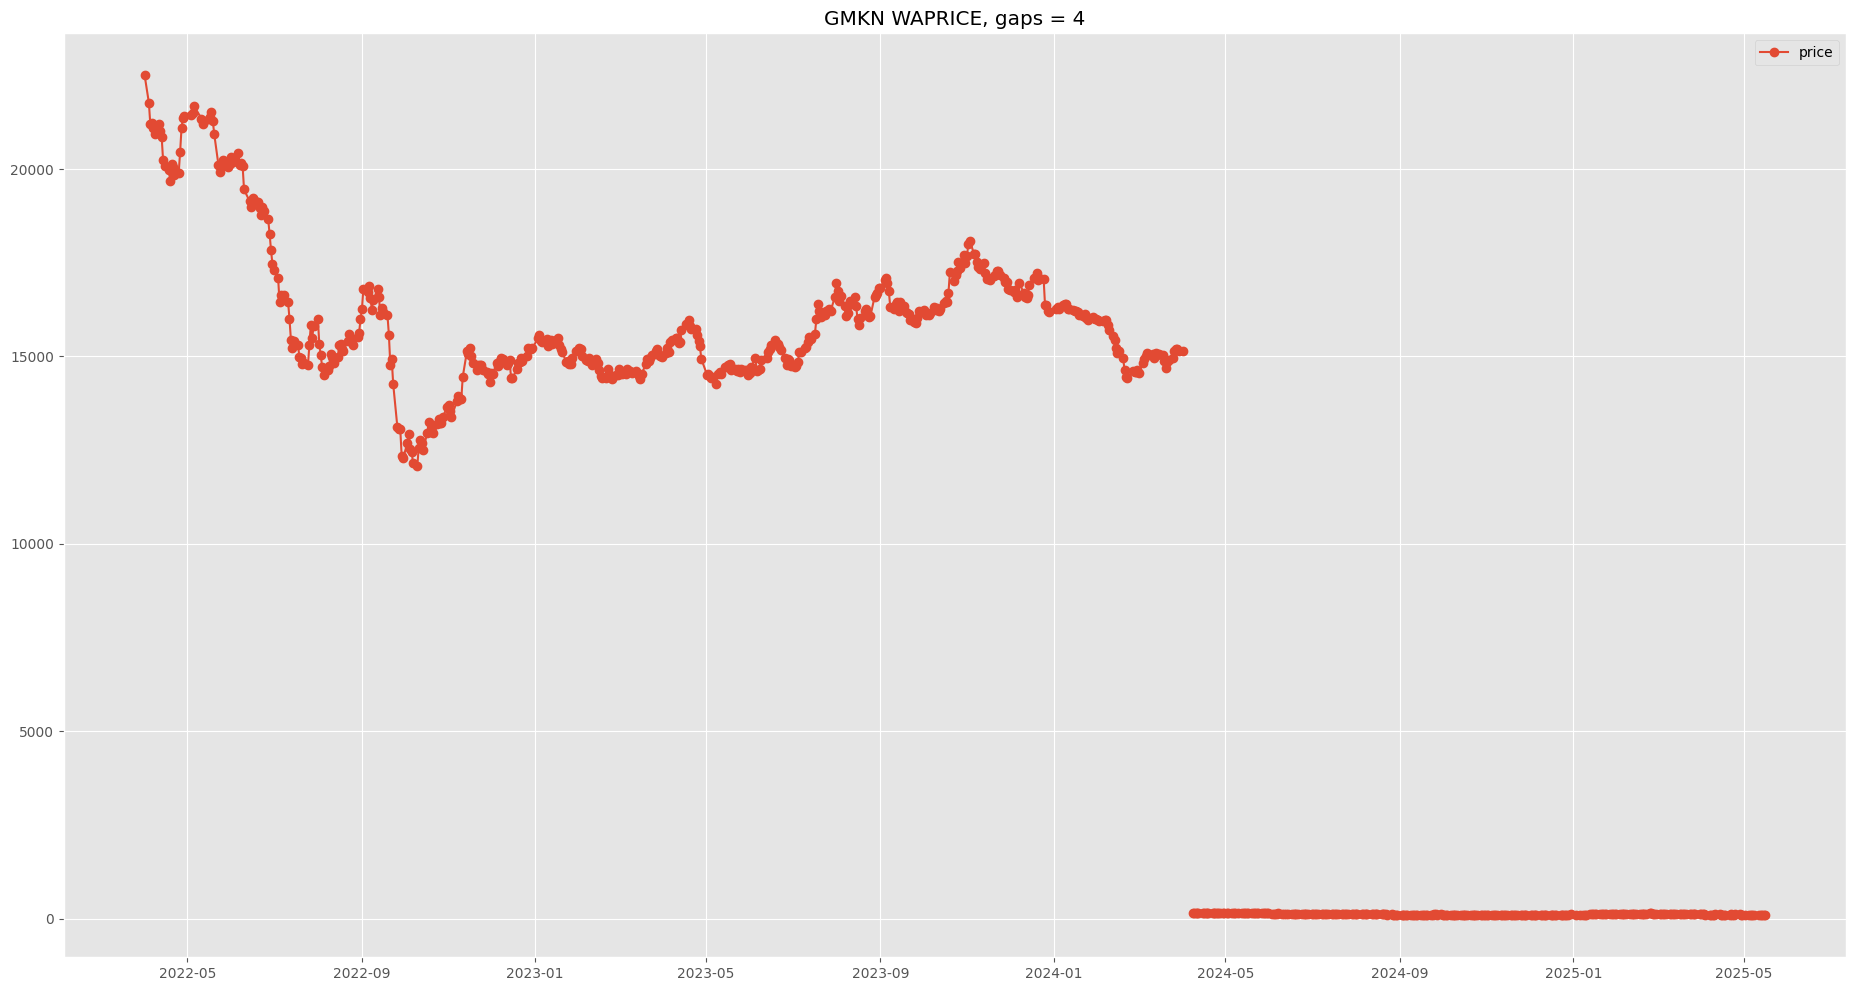

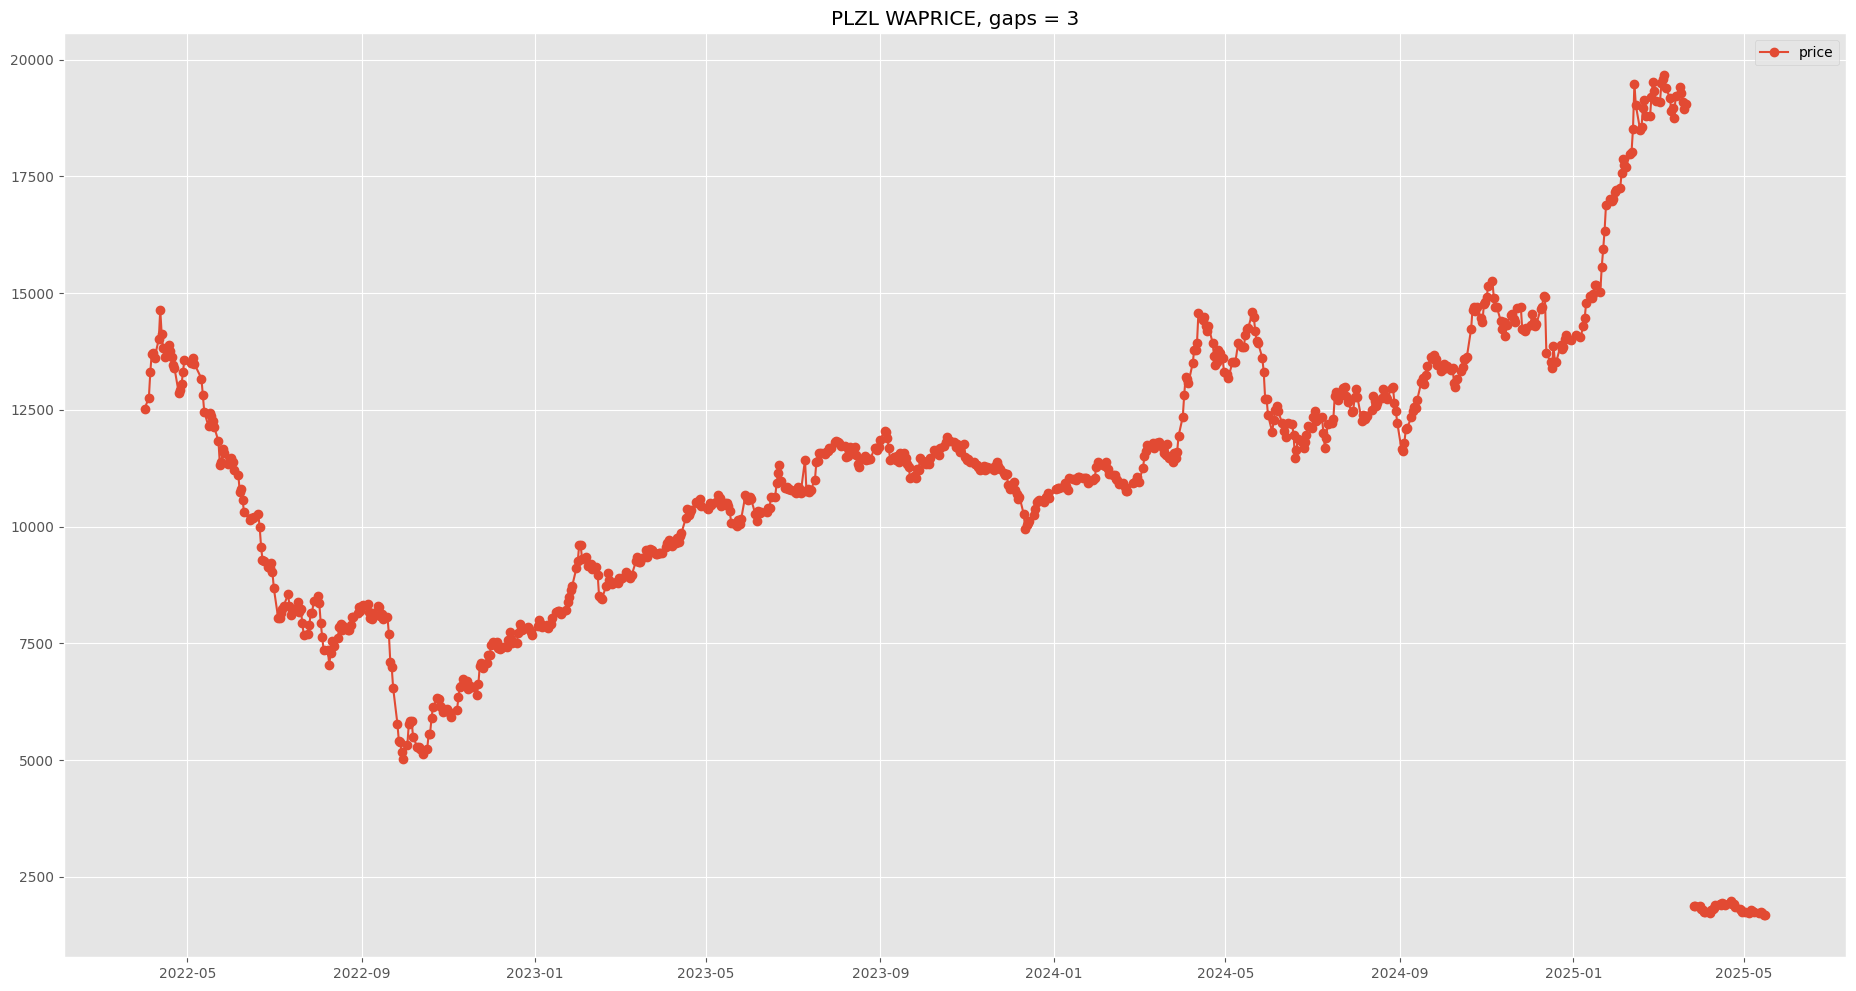

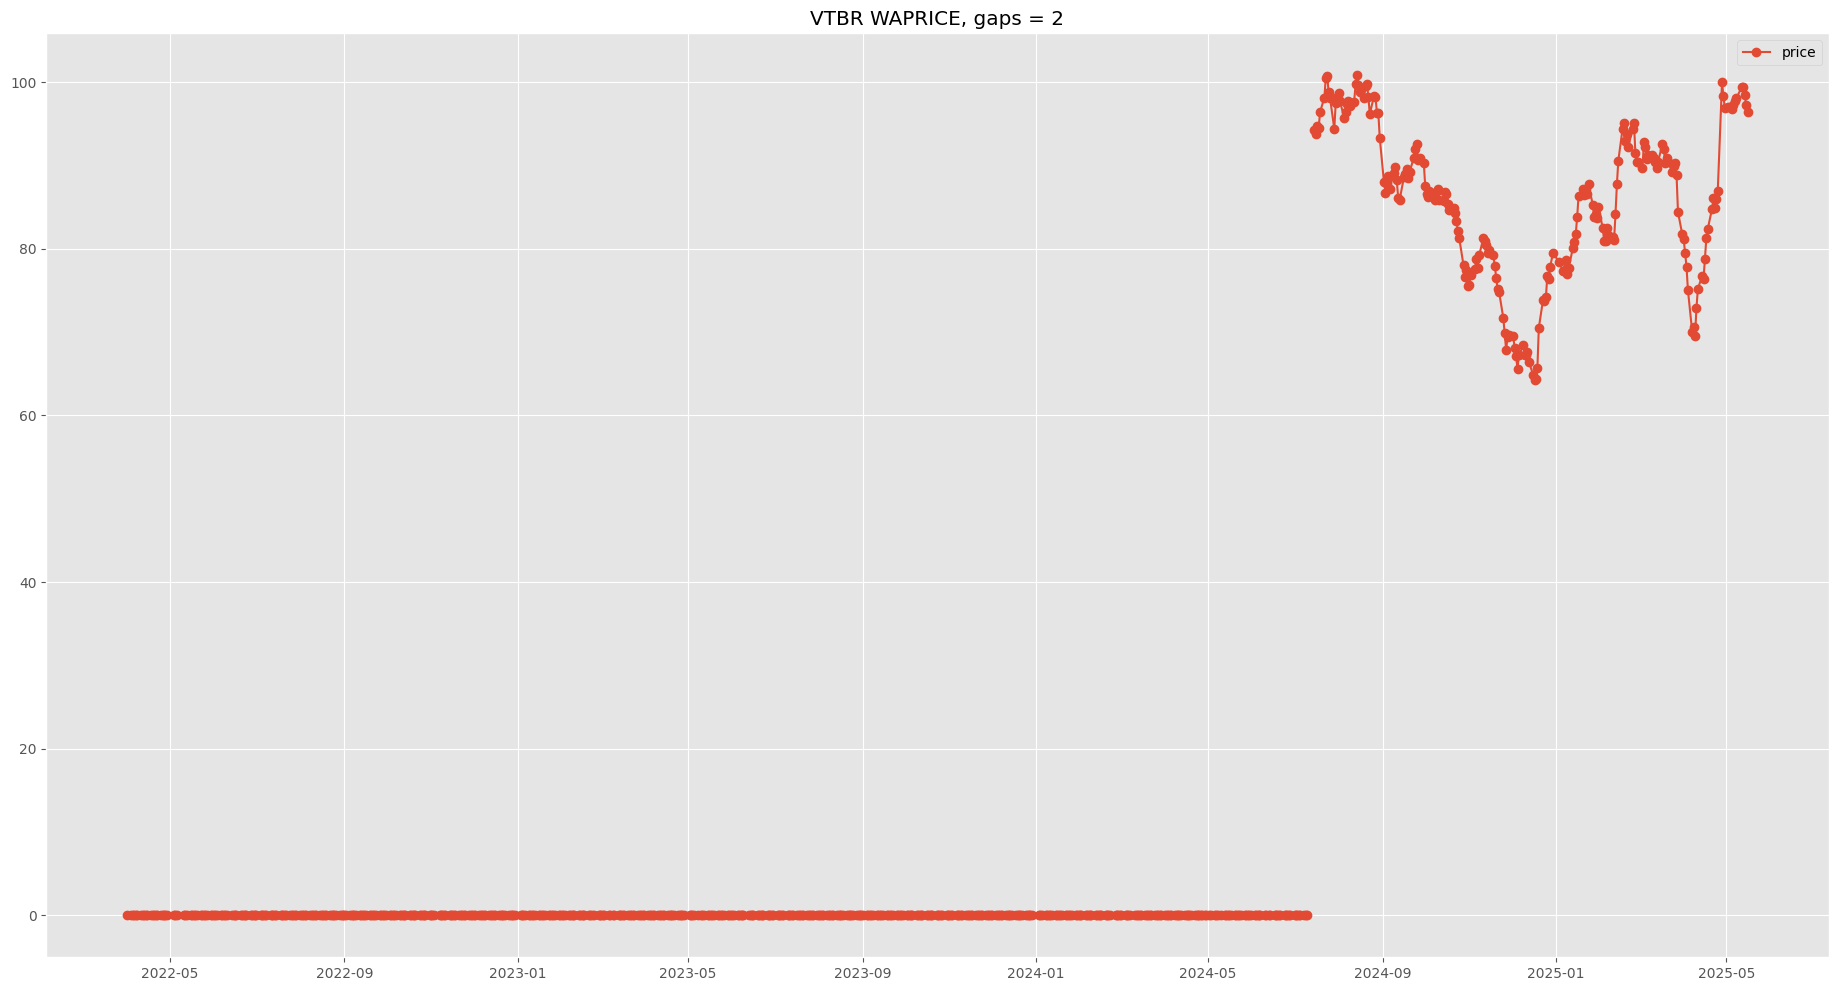

In [11]:
for ticker in list_of_tickers_with_gaps.index[list_of_tickers_with_gaps.values > 0]:
    plt.figure(figsize=(23, 12))

    plt.title(f'{ticker} WAPRICE, gaps = {list_of_tickers_with_gaps[ticker]}')

    plt.plot(df[df['SECID'] == ticker]['WAPRICE'], 
             marker='o',
             label='price')

    plt.legend()

Заполним пропуски через интерполияцию для следующих тикеров:

- YDEX
- VKCO
- FEES

У этих тикеров были сплиты или объединения акций, скорректируем историческую цену на нынешнее состояние а потом интерполируем пропуски там, где они были:

- TRNFP - сплит 100:1
- GMKN - сплит 100:1
- PLZL - сплит 10:1
- VTBR - обратный сплит 0,0002:1


##### Корректируем показатели после сплитов

In [12]:
tickers_to_correct = {
    'TRNFP': (100, pd.to_datetime('19.02.2024', format='%d.%m.%Y')),
    'GMKN': (100, pd.to_datetime('04.04.2024', format='%d.%m.%Y')),
    'PLZL': (10, pd.to_datetime('27.03.2025', format='%d.%m.%Y')),
    'VTBR': (0.0002, pd.to_datetime('15.07.2024', format='%d.%m.%Y')),
}

In [13]:
df_copy = df.copy()

In [14]:
for t in tickers_to_correct.items():
    print(t)

('TRNFP', (100, Timestamp('2024-02-19 00:00:00')))
('GMKN', (100, Timestamp('2024-04-04 00:00:00')))
('PLZL', (10, Timestamp('2025-03-27 00:00:00')))
('VTBR', (0.0002, Timestamp('2024-07-15 00:00:00')))


In [15]:
for ticker, item in tickers_to_correct.items():
    value = item[0]
    split_date = item[1]

    df_ticker_before_split = df_copy[(df_copy['SECID'] == ticker) & (df_copy.index < split_date)]
    # df_ticker_after_split = df_copy[(df_copy['SECID'] == ticker) & (df_copy.index >= split_date)]

    df_ticker_before_split = pd.concat([
        df_ticker_before_split.loc[:, 'SECID'],
        df_ticker_before_split.loc[:, ['WAPRICE', 'OPEN', 'CLOSE', 'LOW', 'HIGH', 'VOLUME']] / value,
        ], axis=1)

    df[(df['SECID'] == ticker) & (df.index < split_date)] = df_ticker_before_split
    

##### Скорректированные тикеры

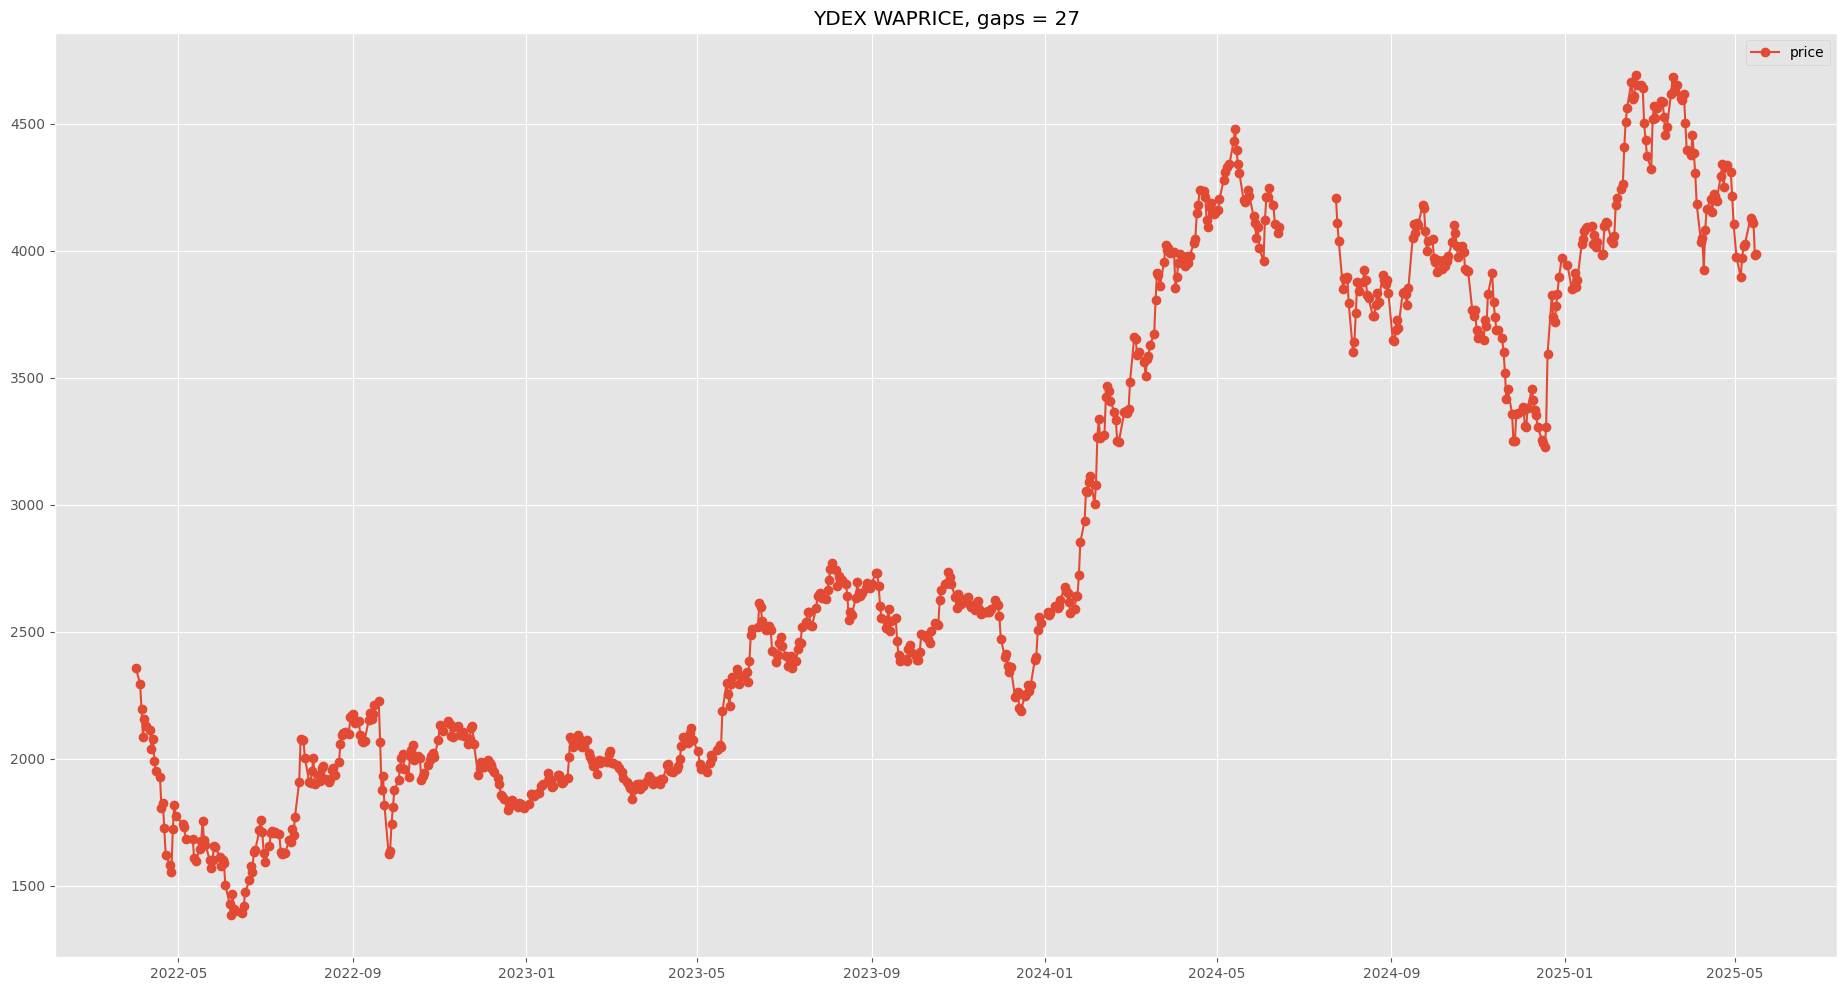

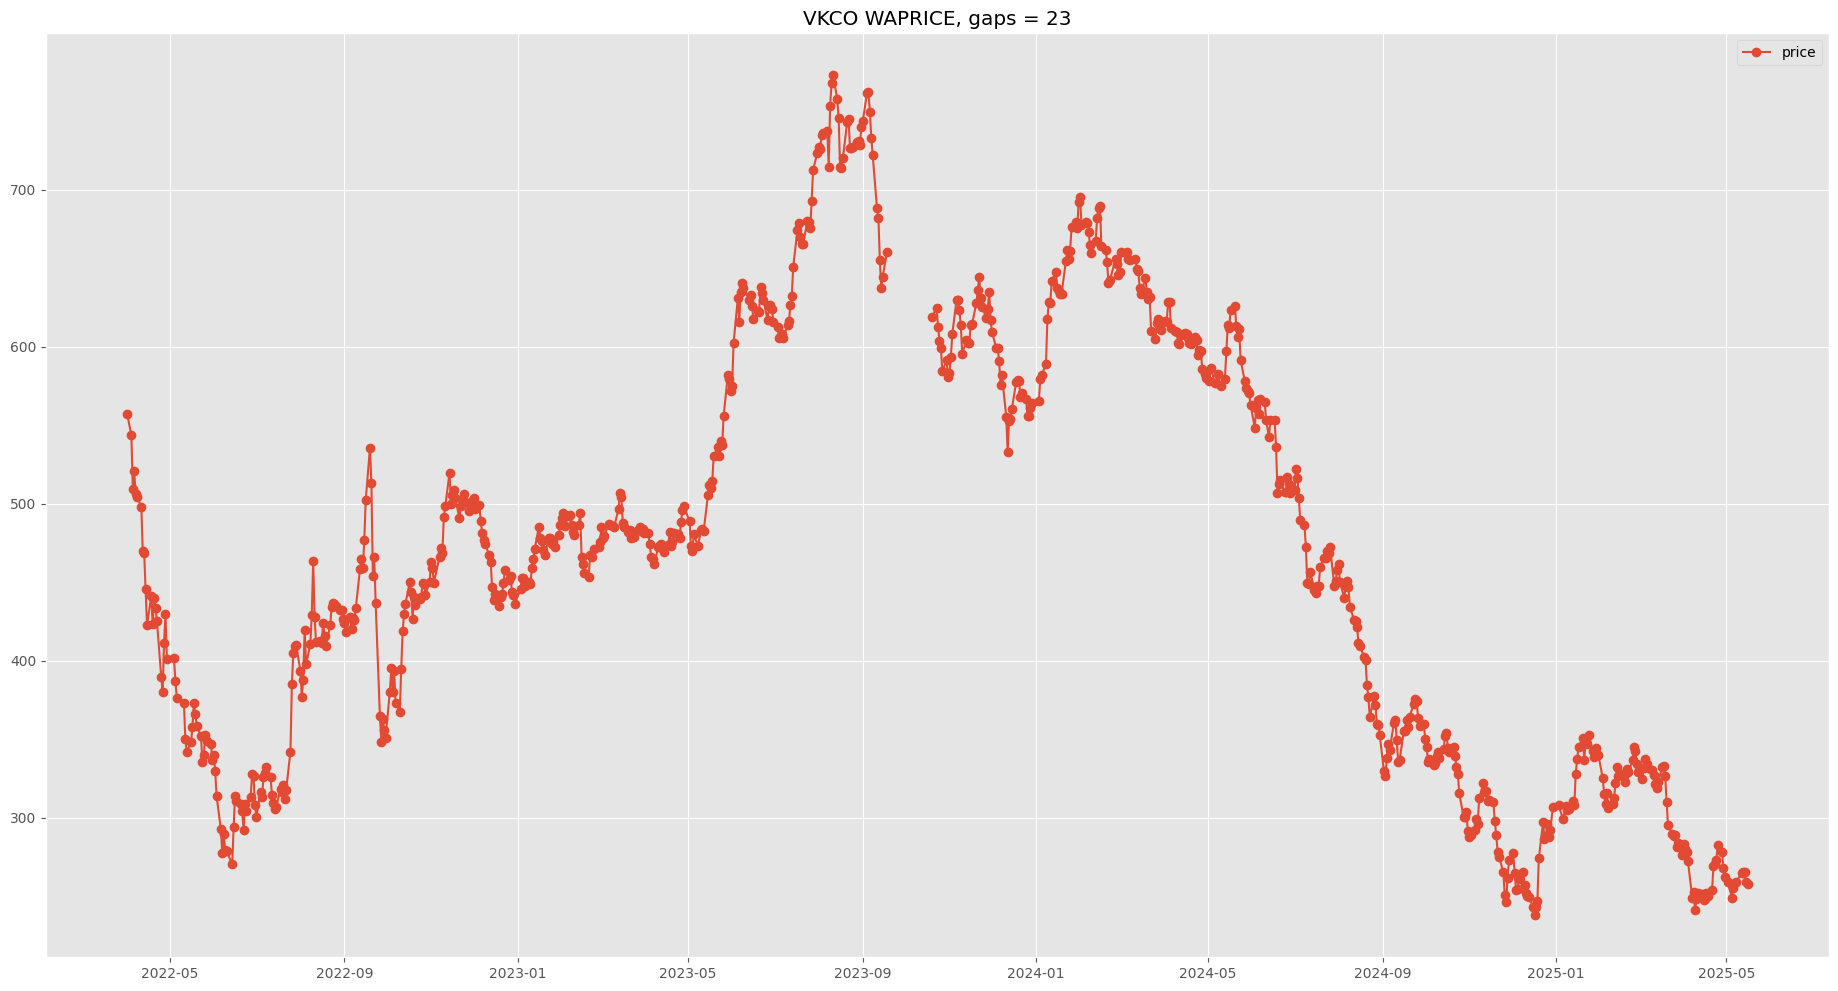

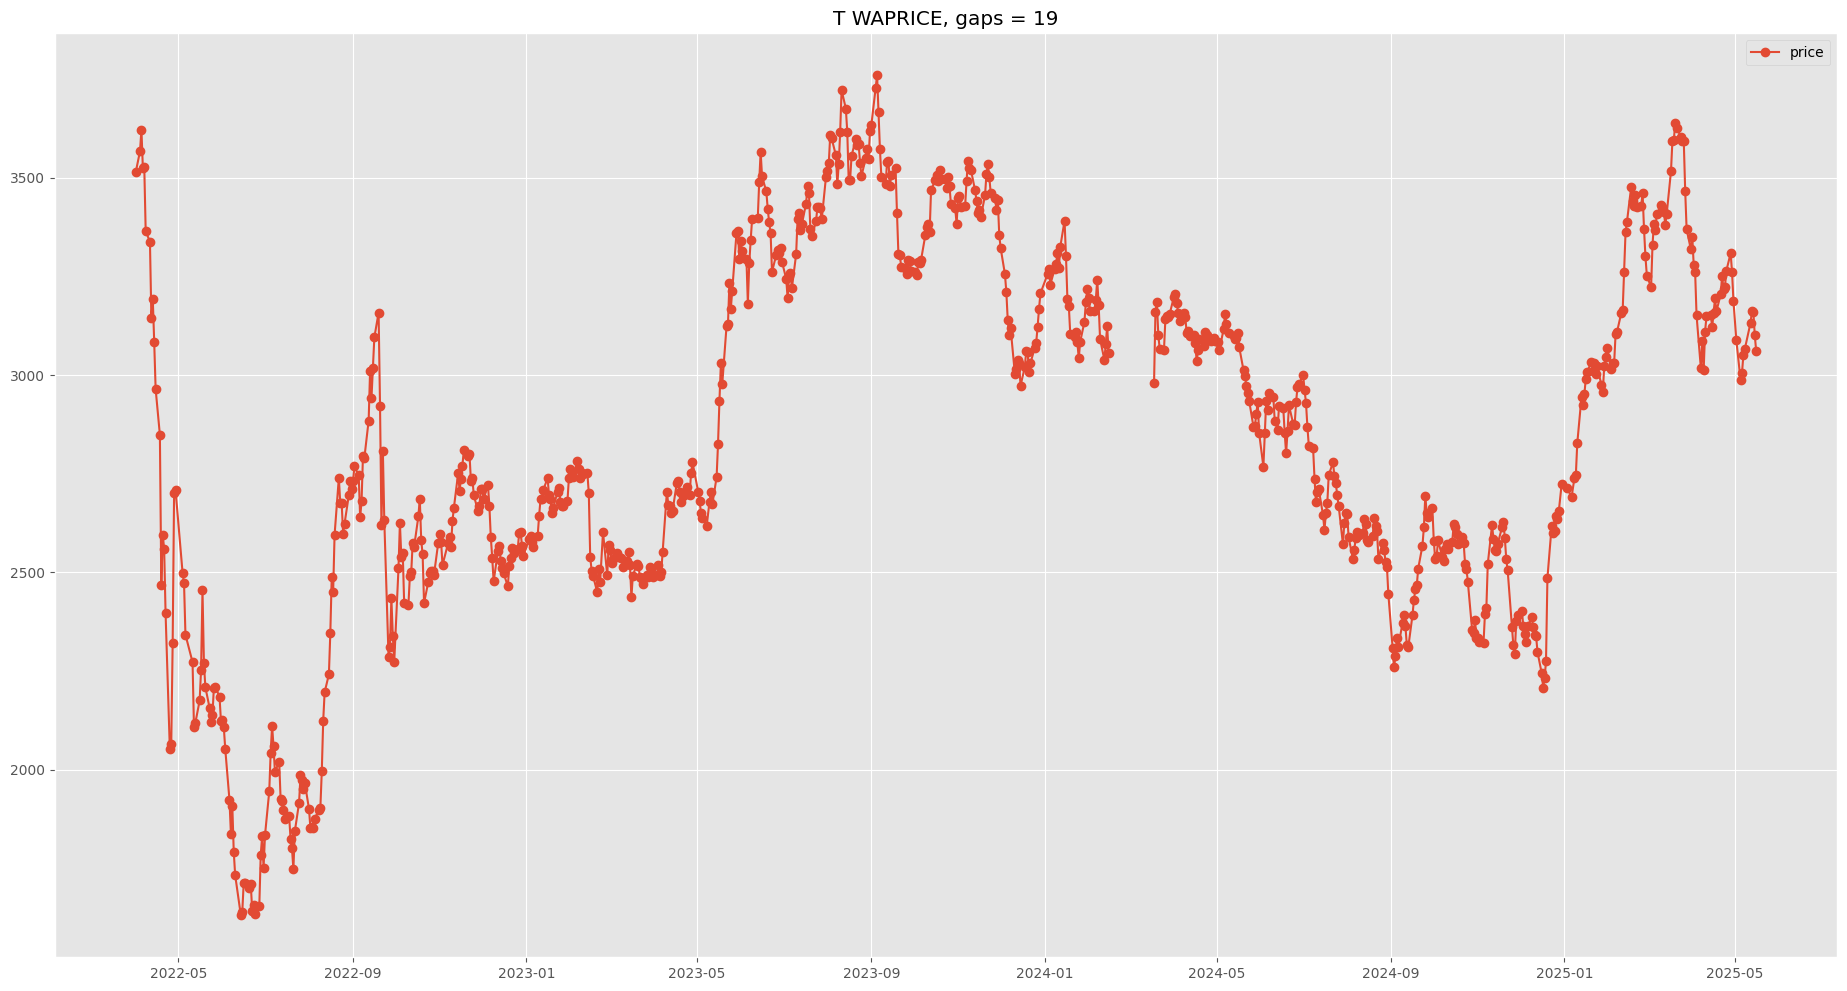

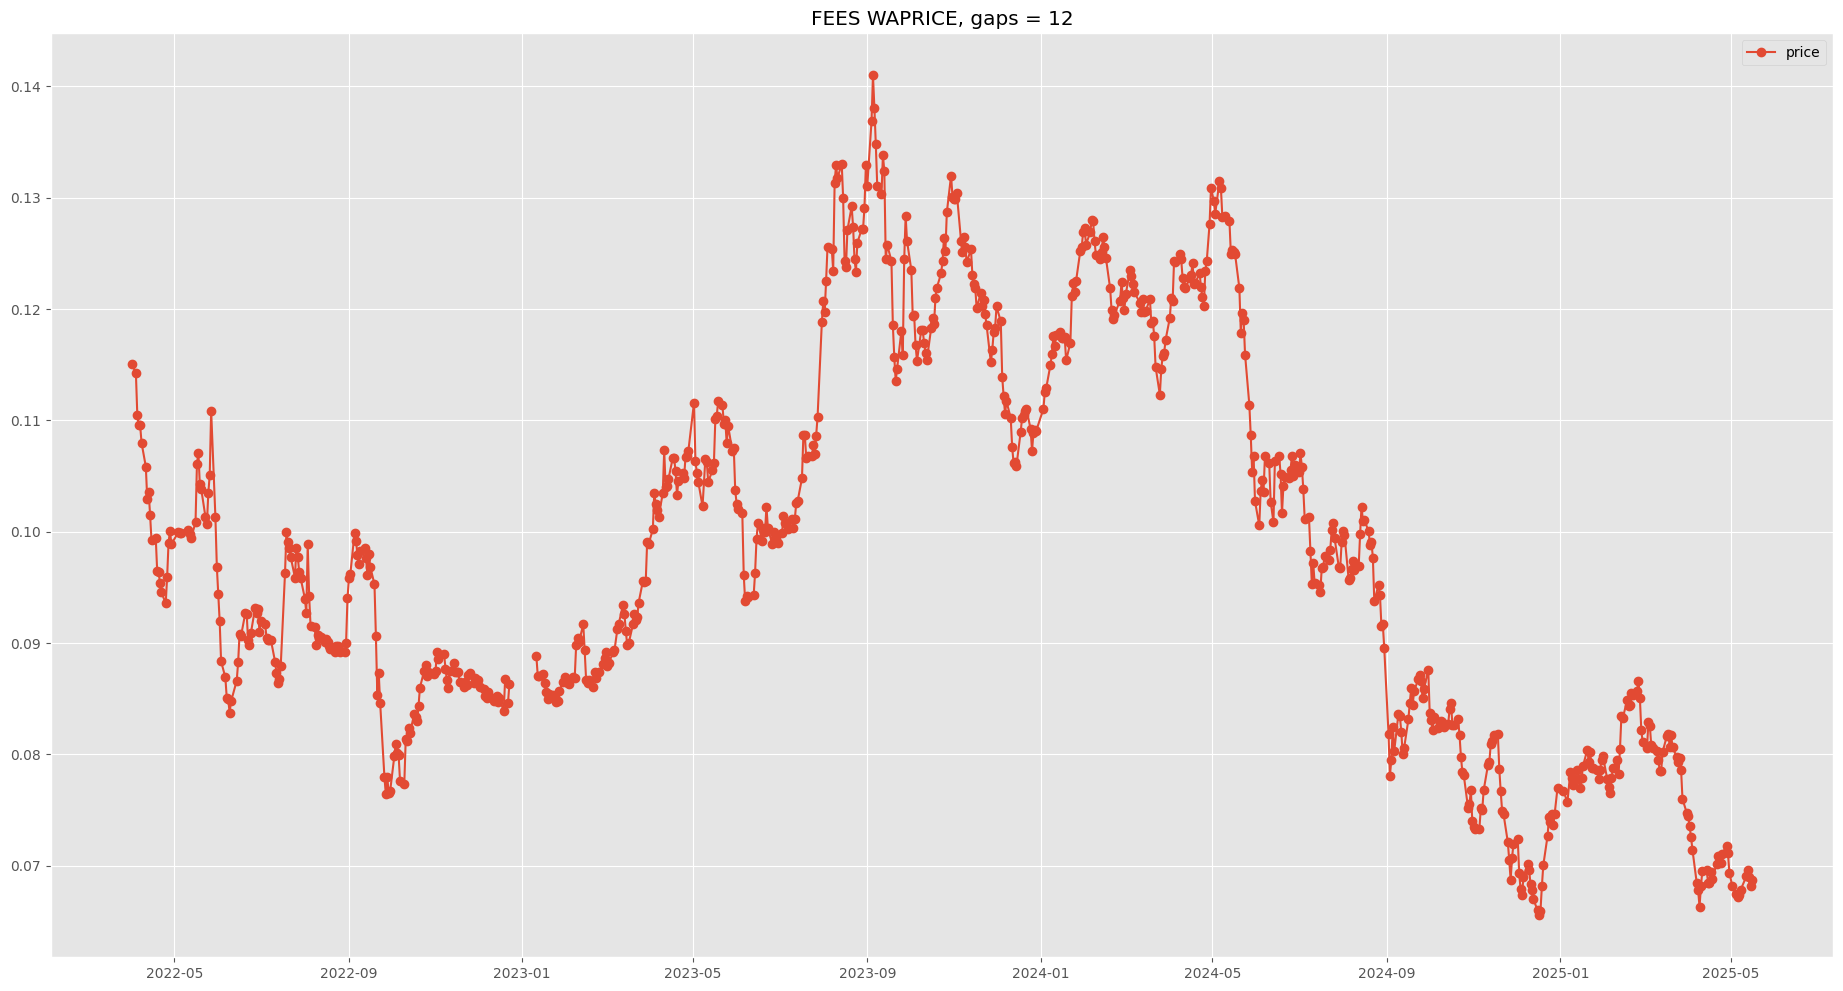

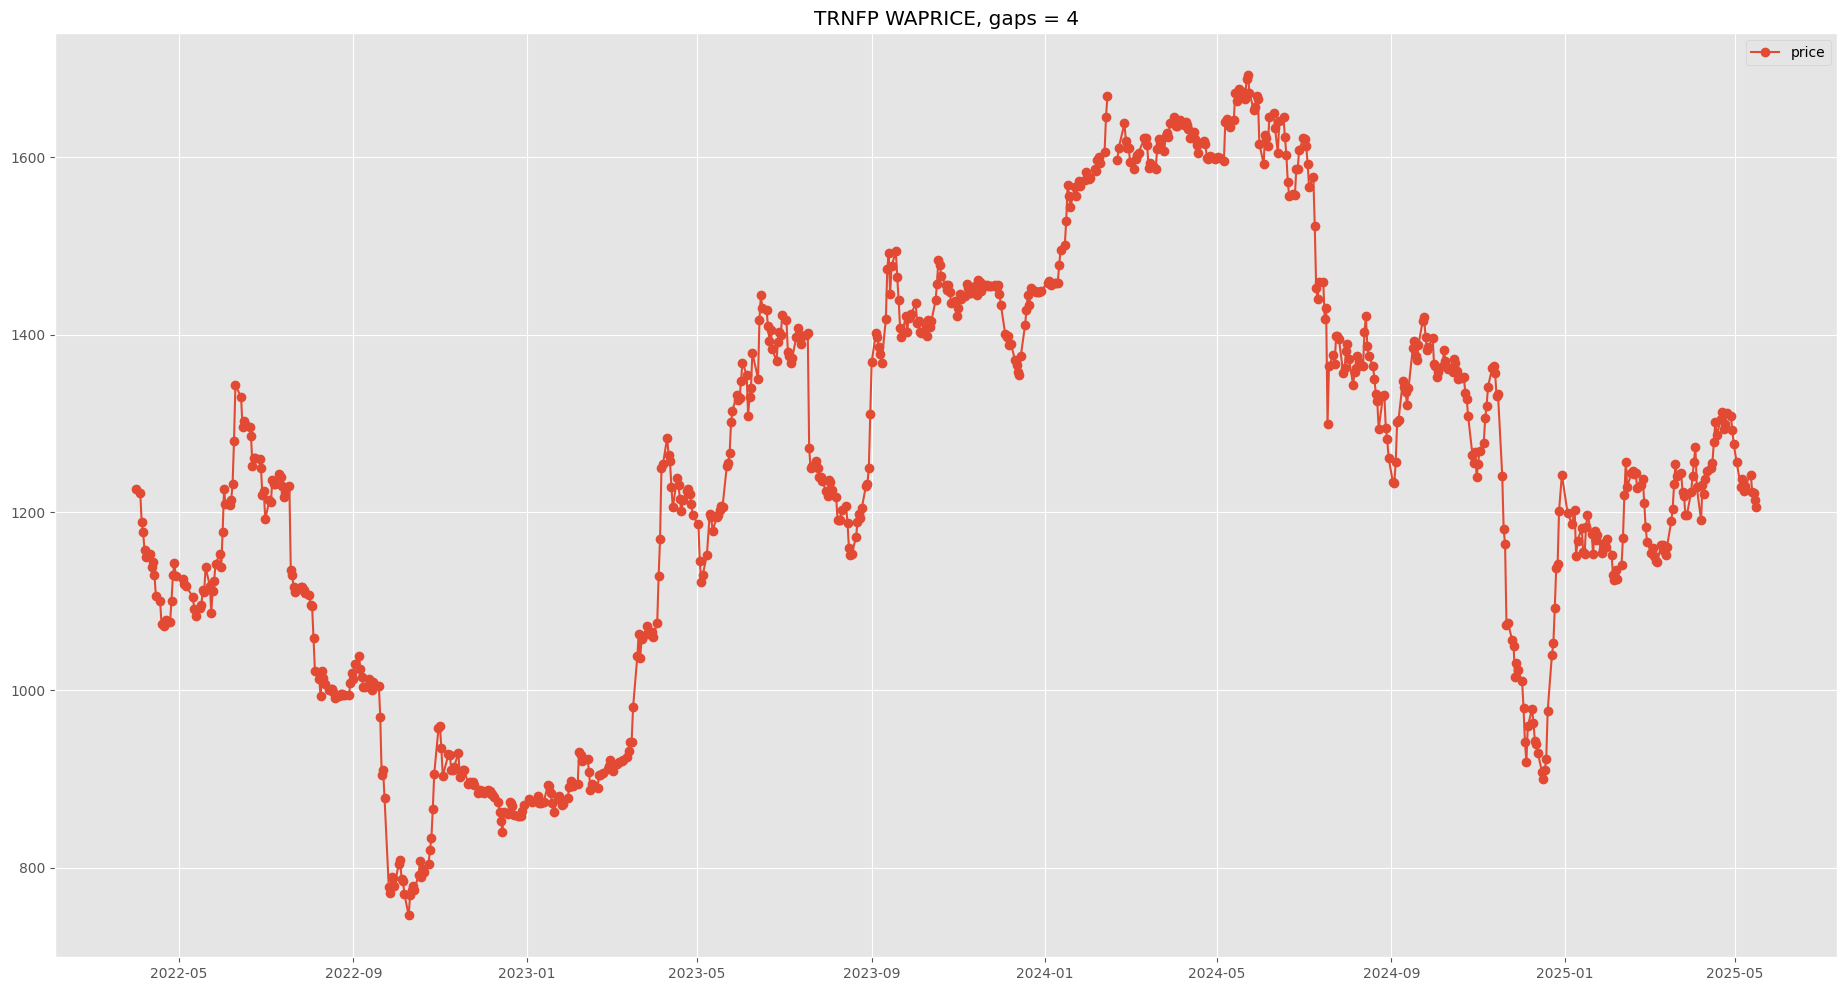

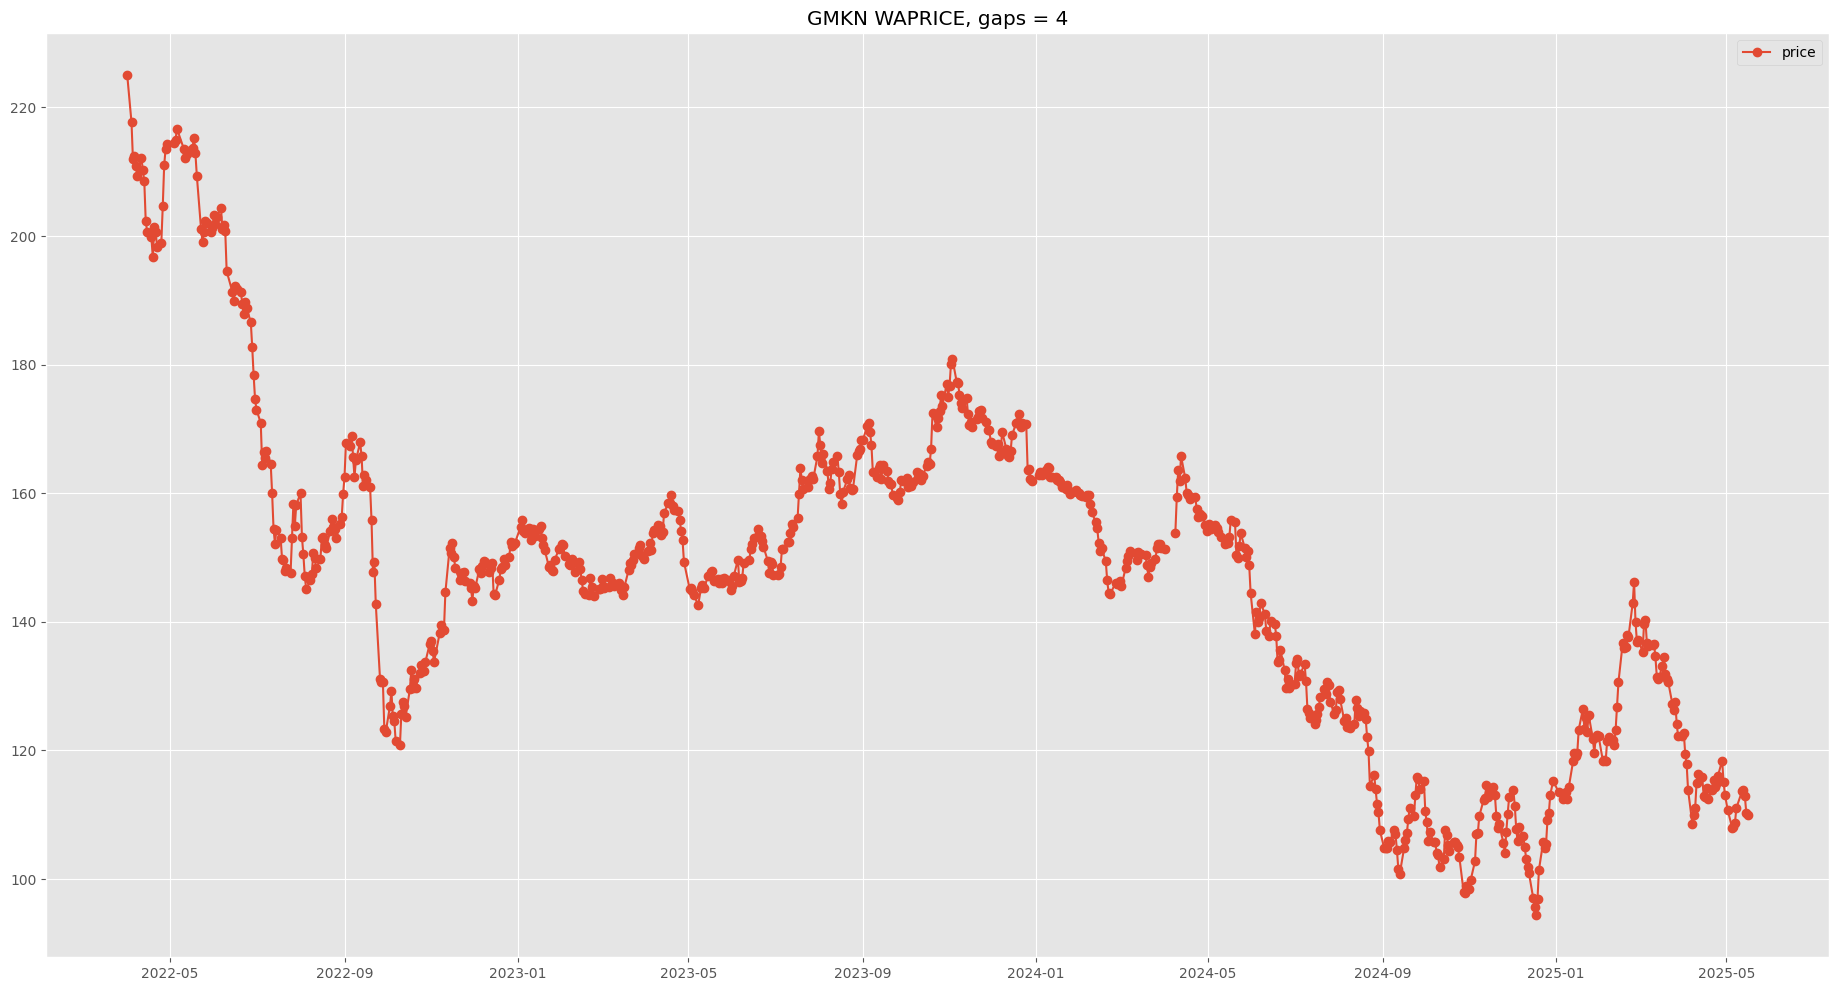

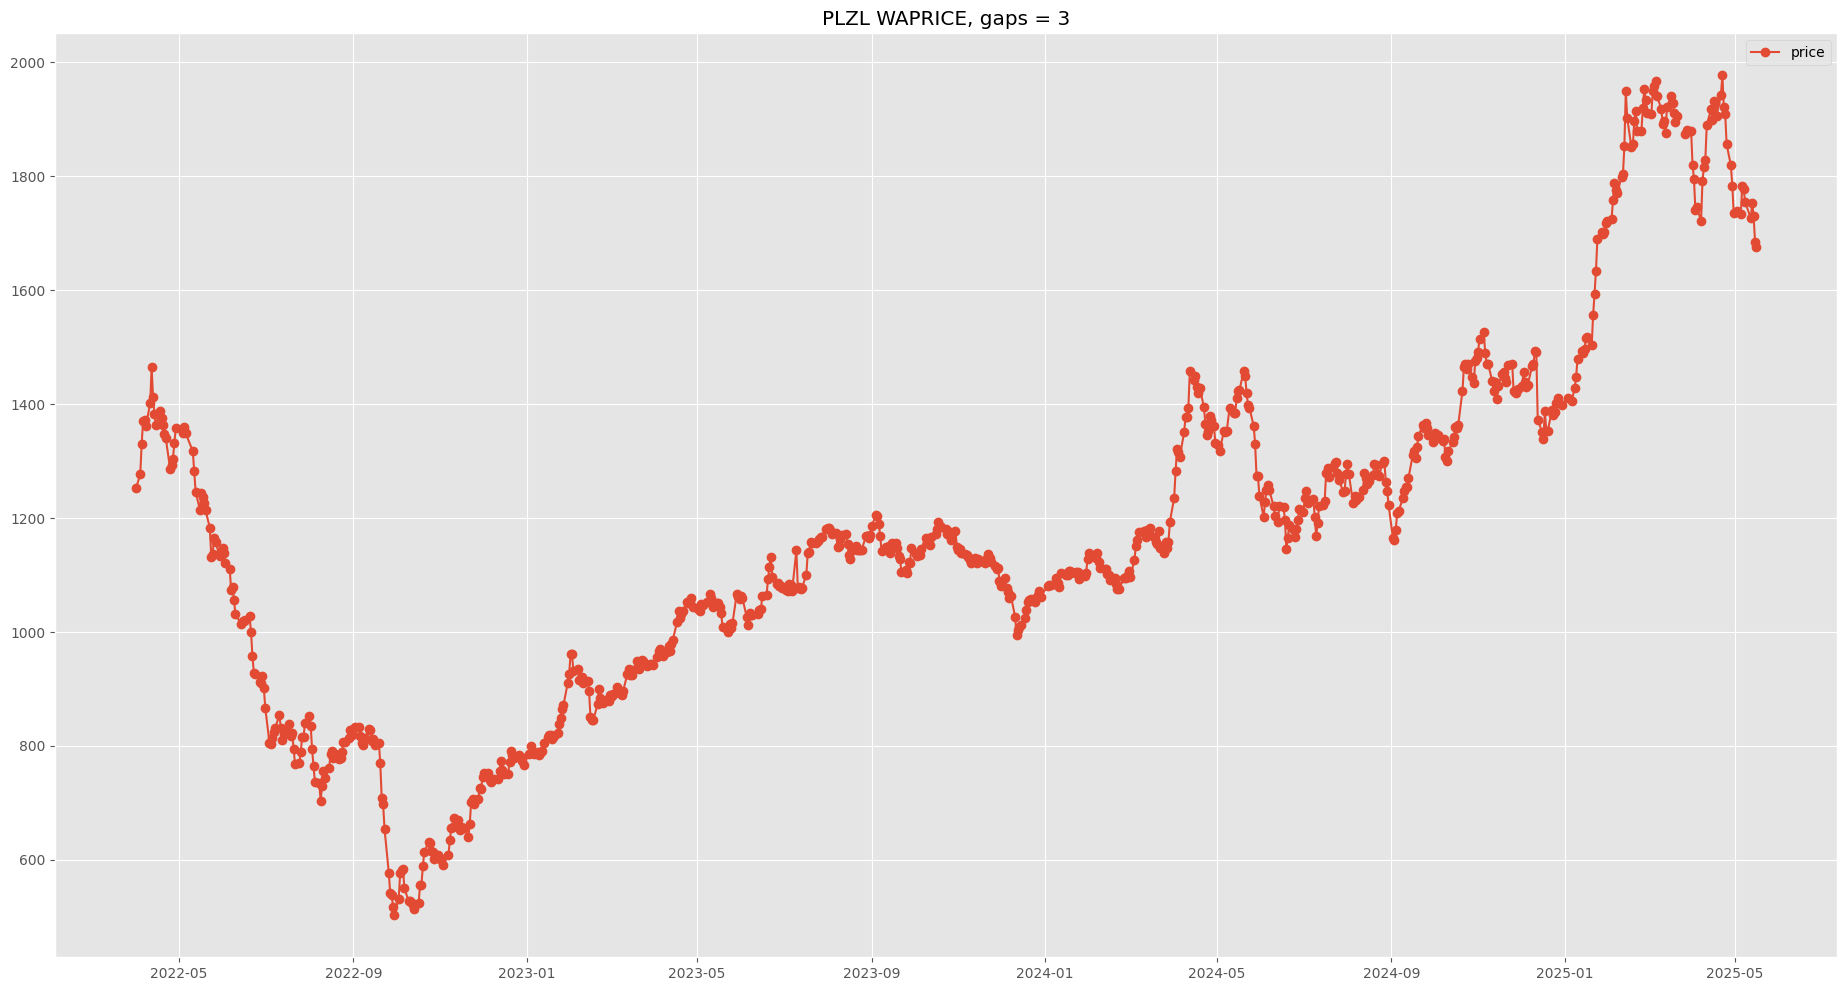

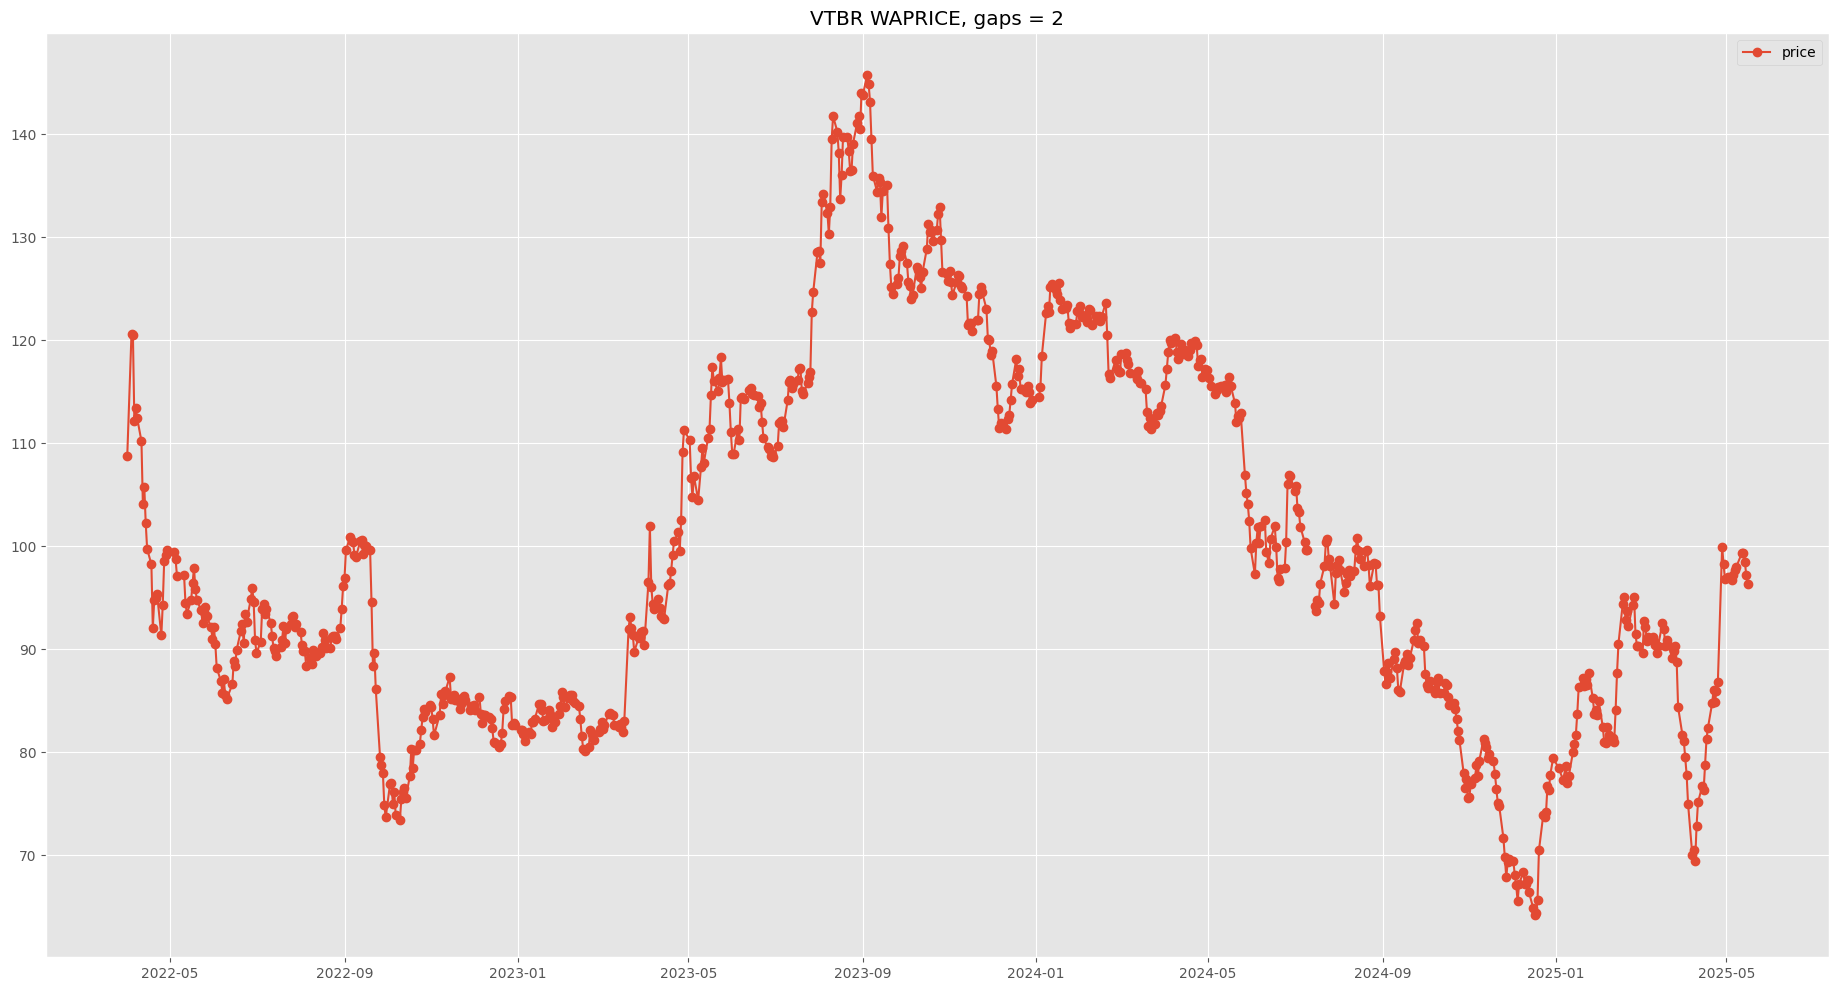

In [16]:
for ticker in list_of_tickers_with_gaps.index[list_of_tickers_with_gaps.values > 0]:
    plt.figure(figsize=(23, 12))

    plt.title(f'{ticker} WAPRICE, gaps = {list_of_tickers_with_gaps[ticker]}')

    plt.plot(df[df['SECID'] == ticker]['WAPRICE'], 
             marker='o',
             label='price')

    plt.legend()

##### Дозаполняем пропуски

In [17]:
list_of_tickers_with_gaps = df.groupby('SECID')['CLOSE'].apply(lambda x: x.isna().sum()).sort_values(ascending=False) 
list_of_tickers_with_gaps

SECID
YDEX     27
VKCO     23
T        19
FEES     14
VTBR      4
TRNFP     4
GMKN      4
PLZL      3
SBERP     0
POSI      0
ROSN      0
RTKM      0
RUAL      0
SBER      0
SNGSP     0
SELG      0
SMLT      0
SNGS      0
PHOR      0
TATN      0
TATNP     0
UPRO      0
PIKK      0
AFKS      0
AFLT      0
NLMK      0
ALRS      0
BSPB      0
CBOM      0
CHMF      0
ENPG      0
FLOT      0
GAZP      0
HYDR      0
IRAO      0
LKOH      0
MAGN      0
MGNT      0
MOEX      0
MSNG      0
MTLR      0
MTLRP     0
MTSS      0
NVTK      0
Name: CLOSE, dtype: int64

Заполняем через интерполяцию (квадратичную)

In [18]:
for ticker in list_of_tickers_with_gaps[list_of_tickers_with_gaps > 0].index:
    df_ticker = df[df['SECID'] == ticker]
    df_ticker = df_ticker.interpolate(method='polynomial', order=2)

    df[df['SECID'] == ticker] = df_ticker

##### Интерполированные пропуски

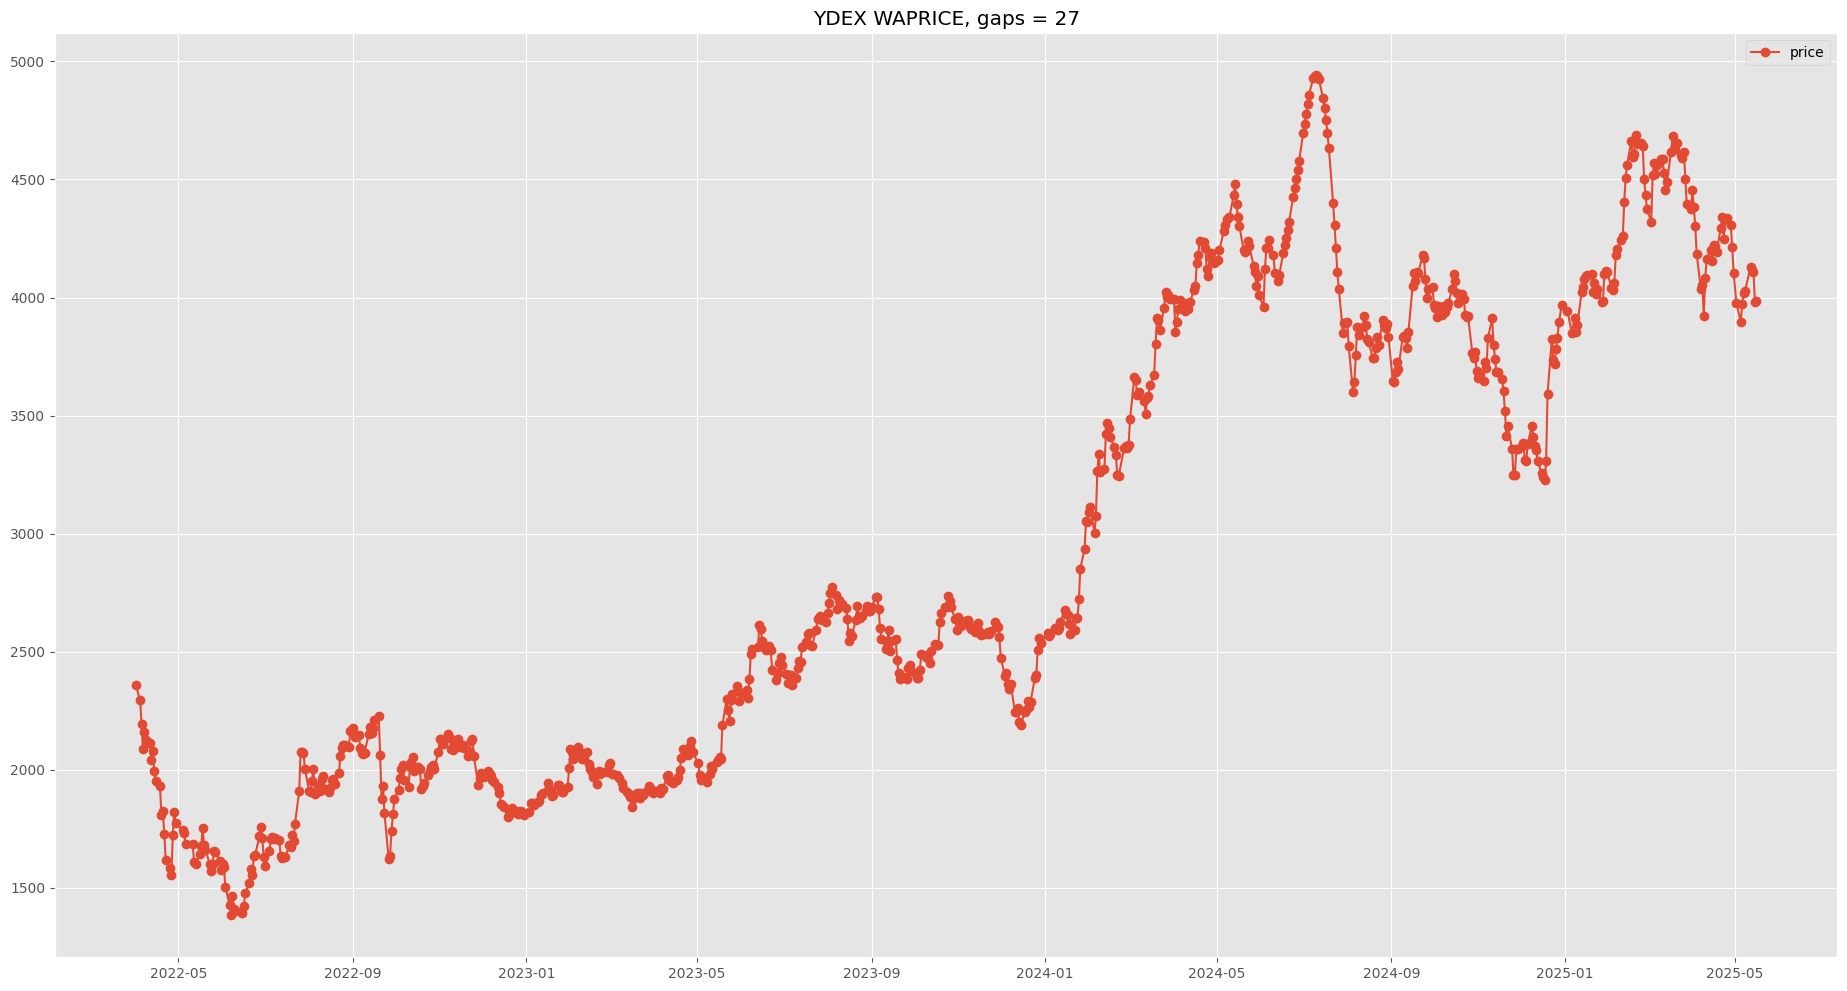

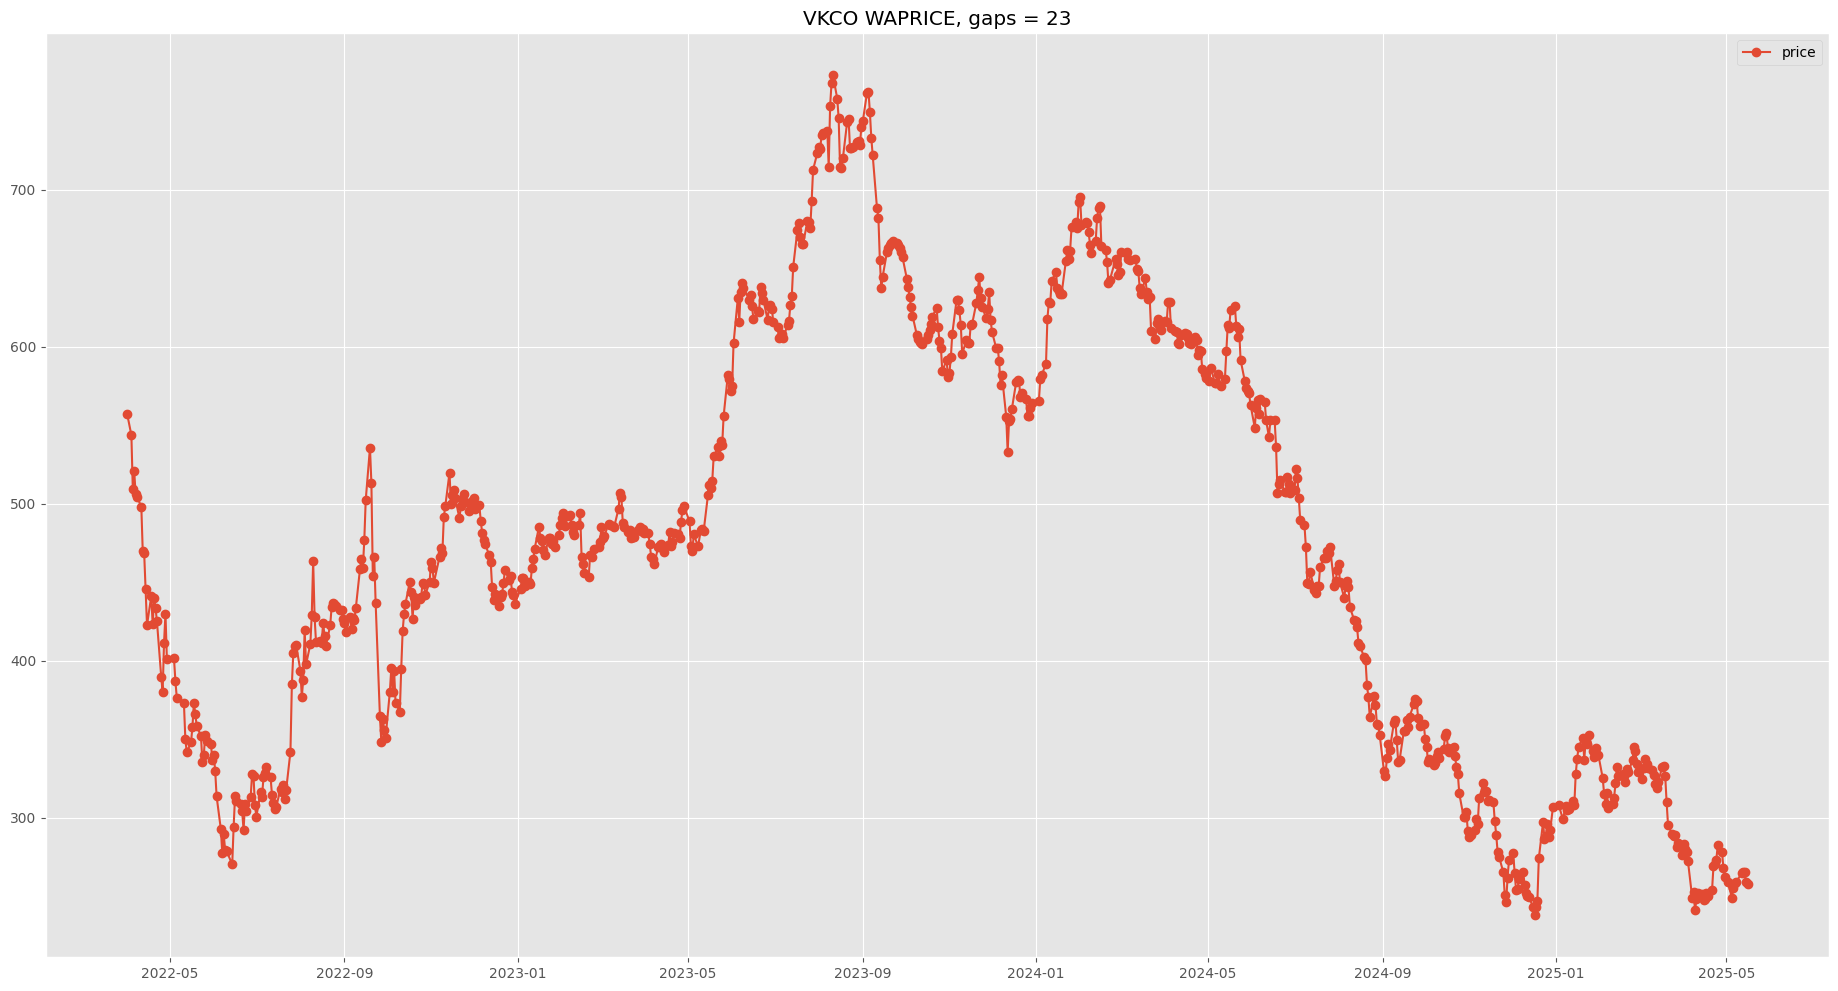

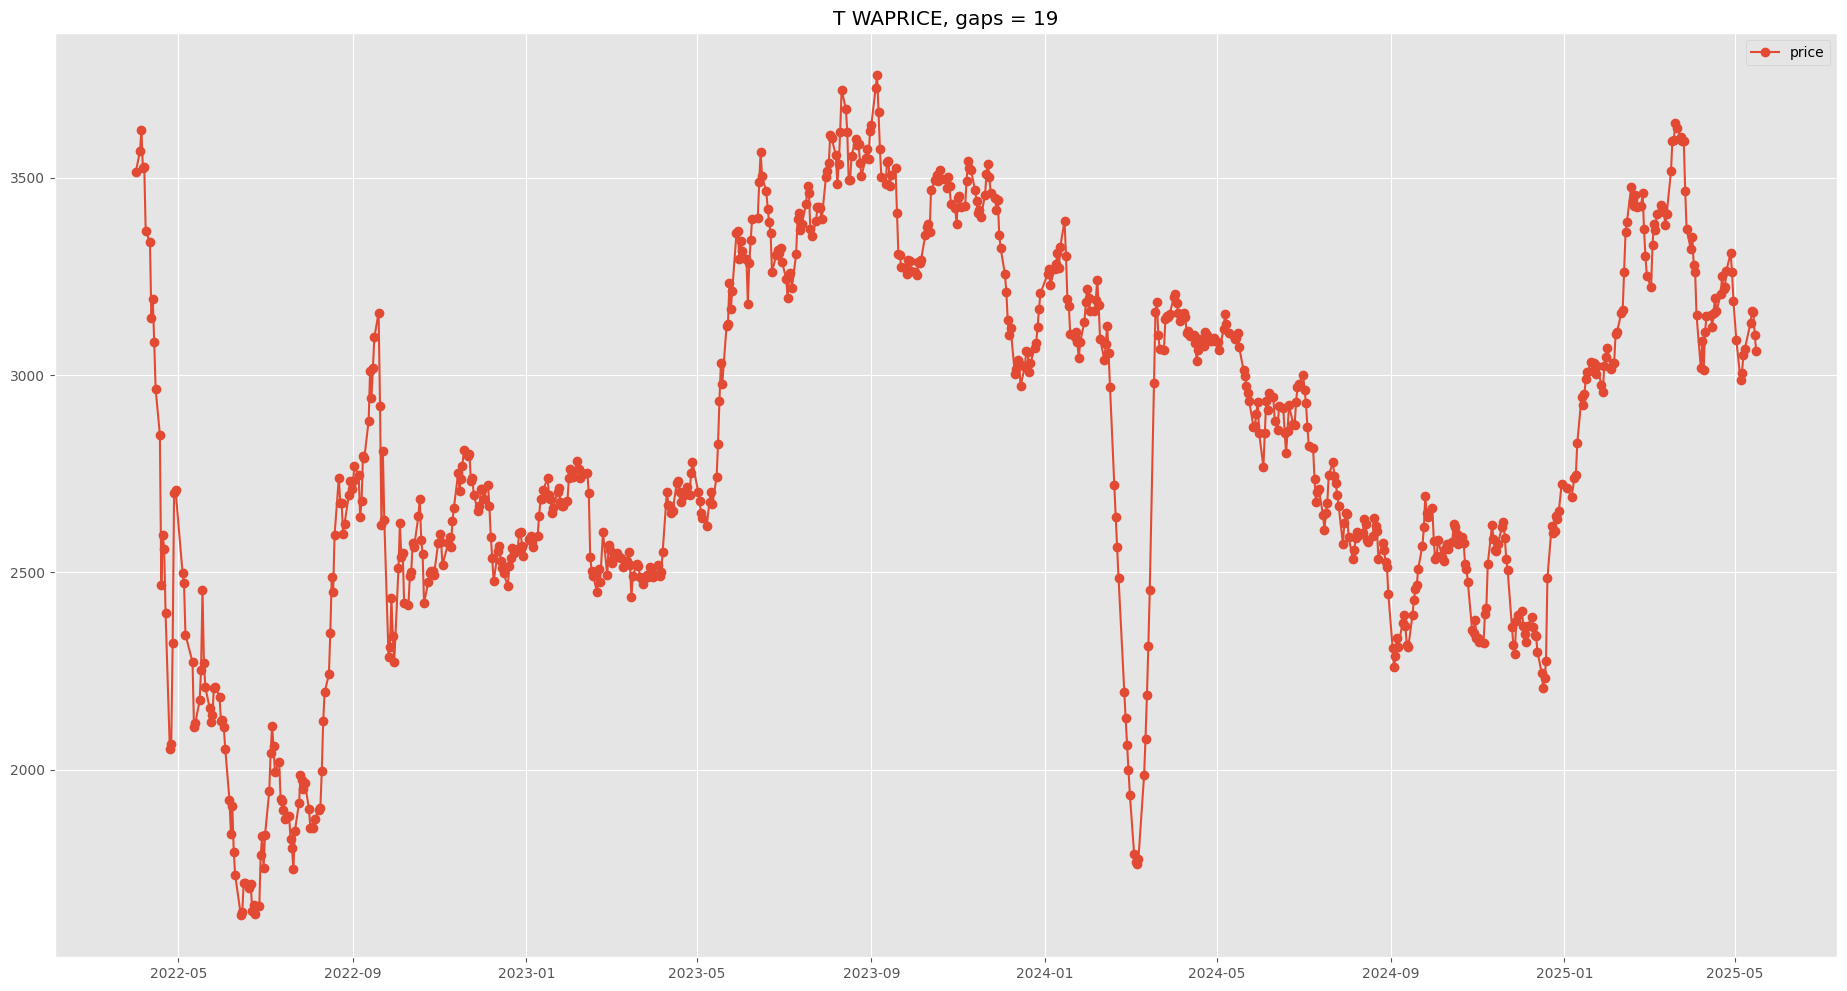

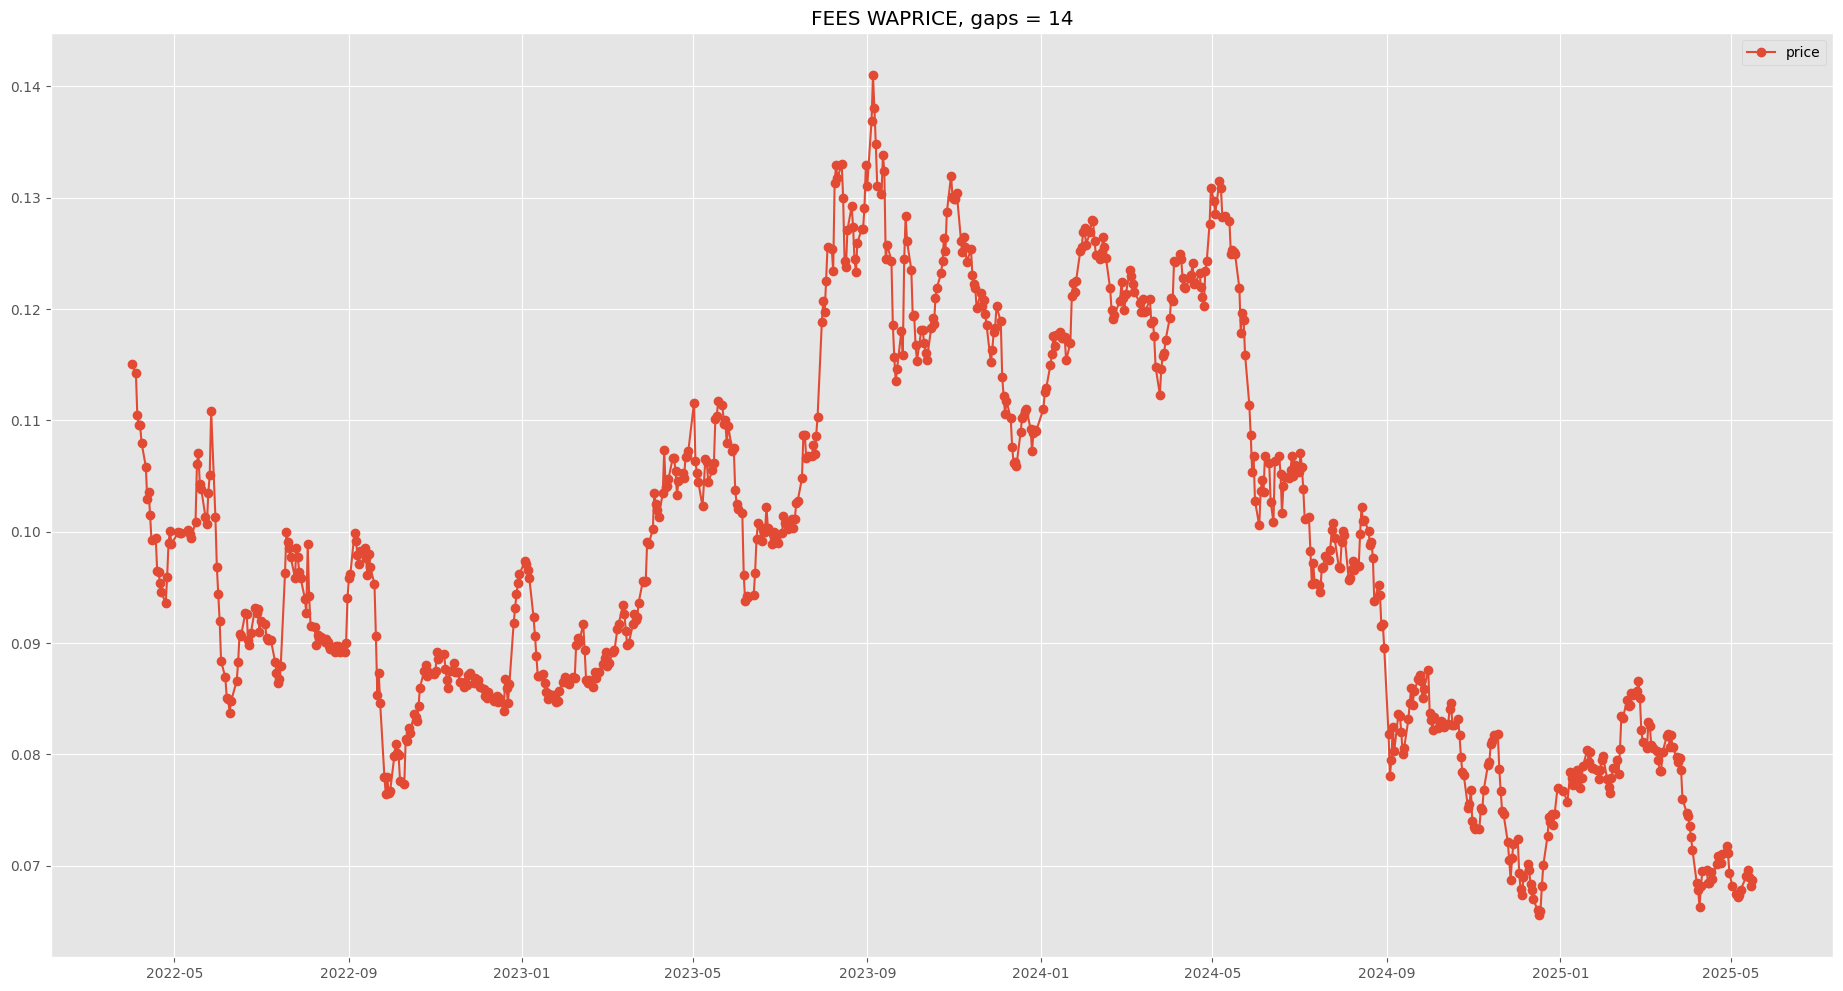

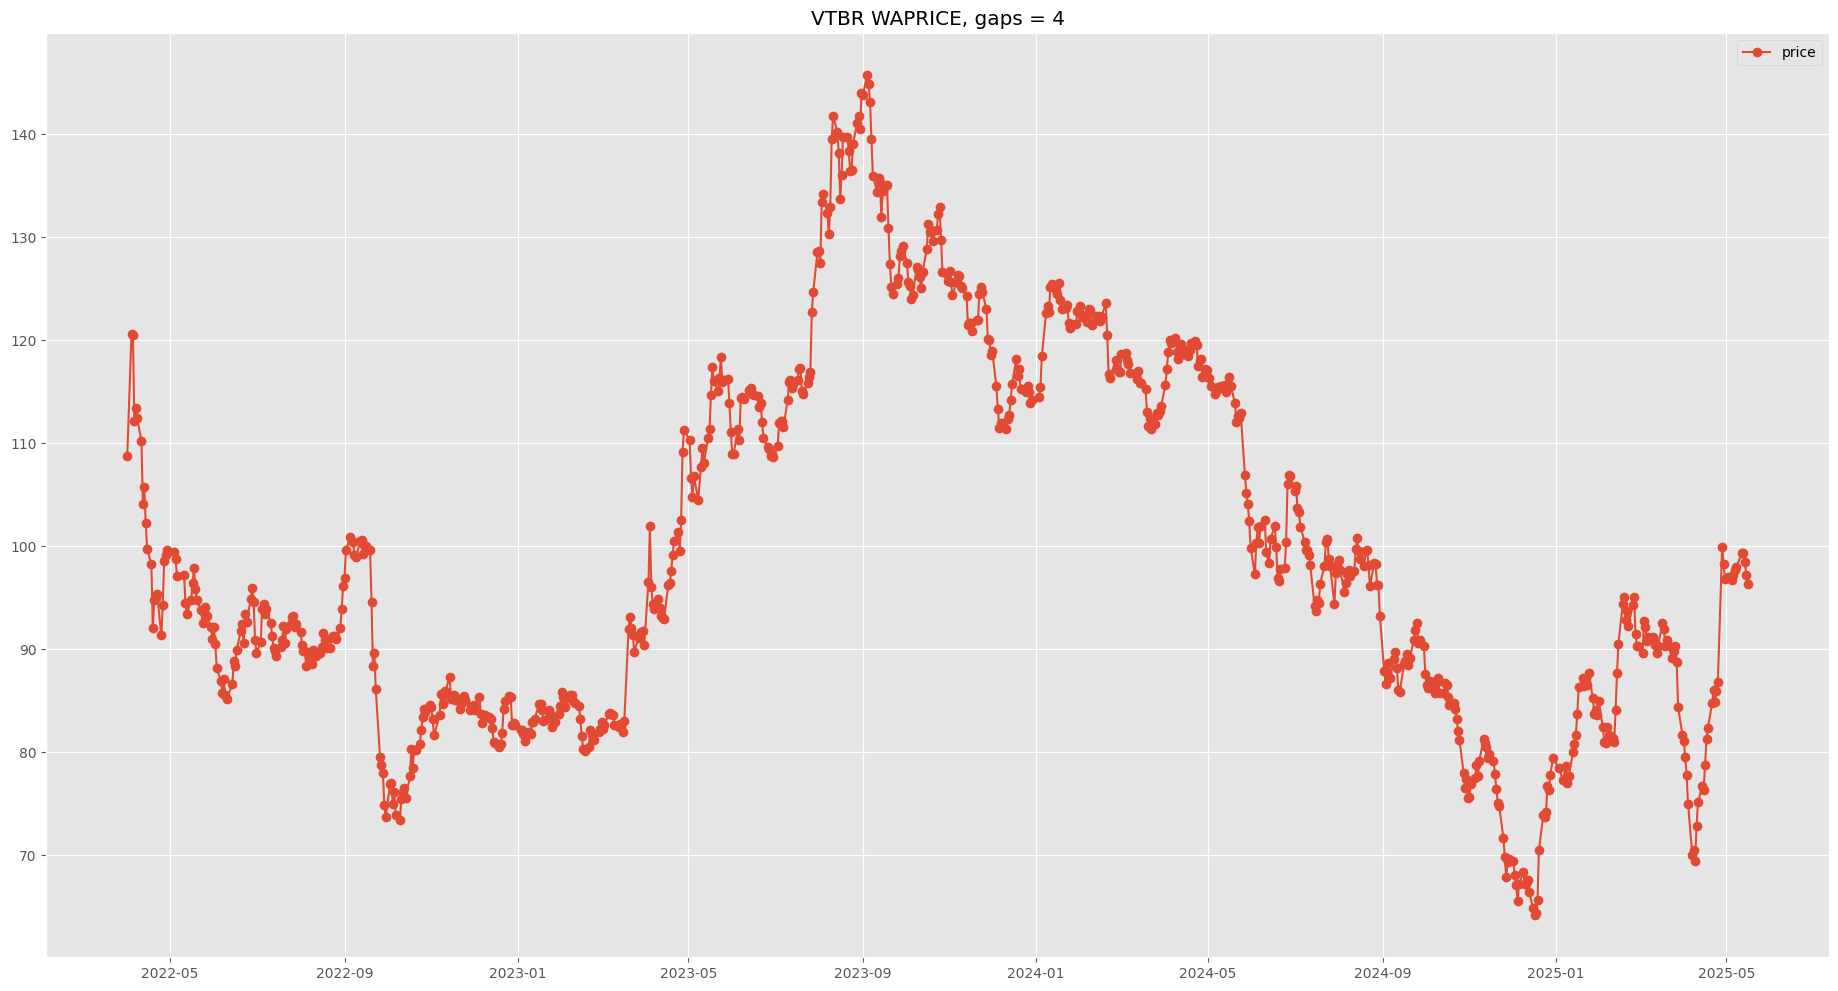

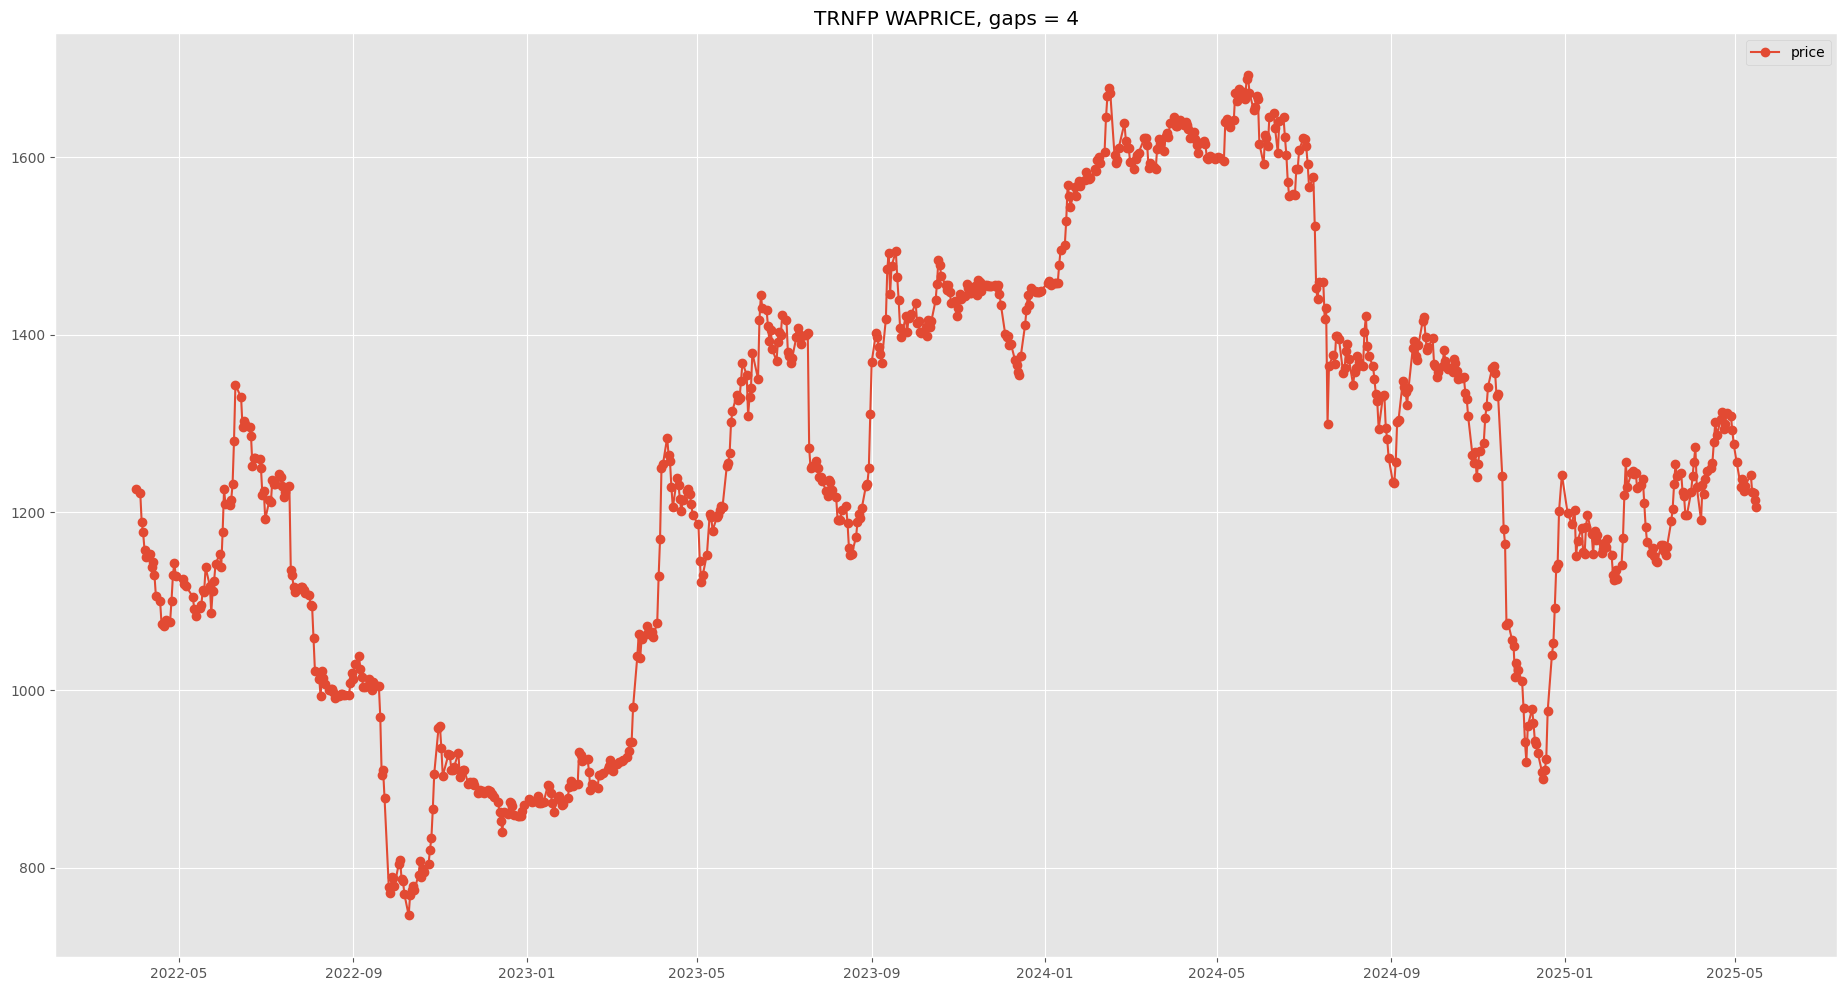

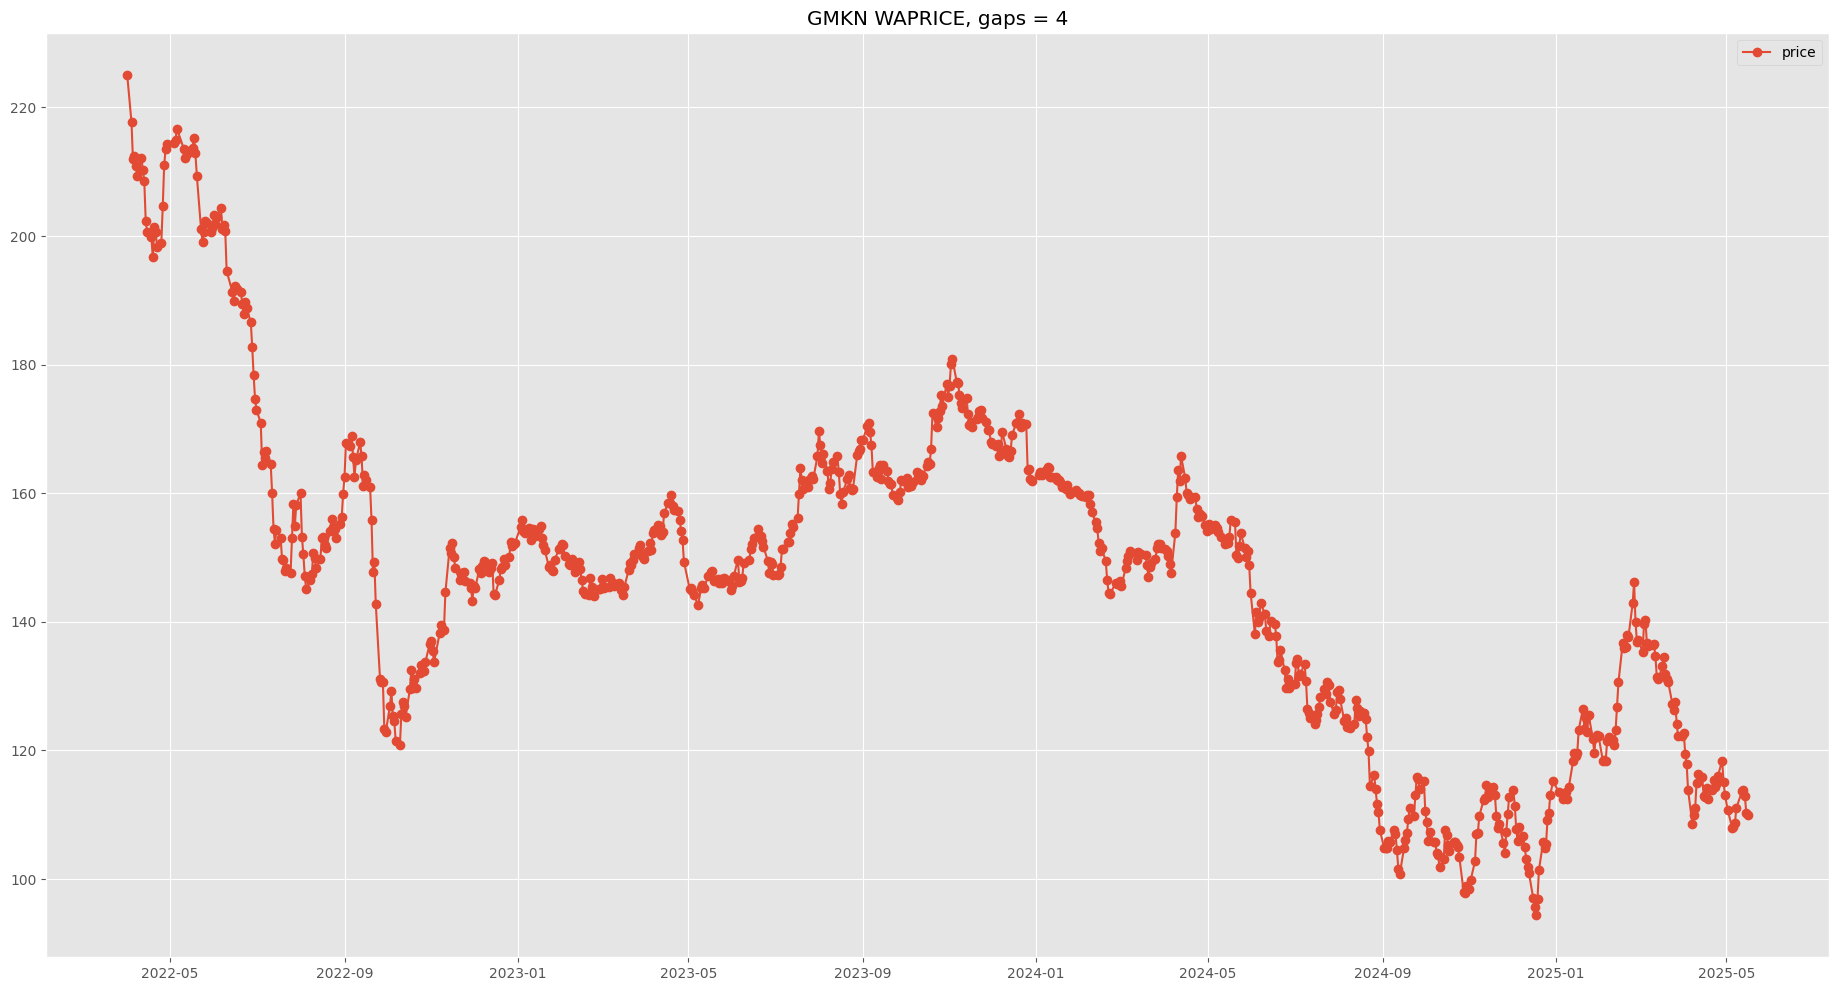

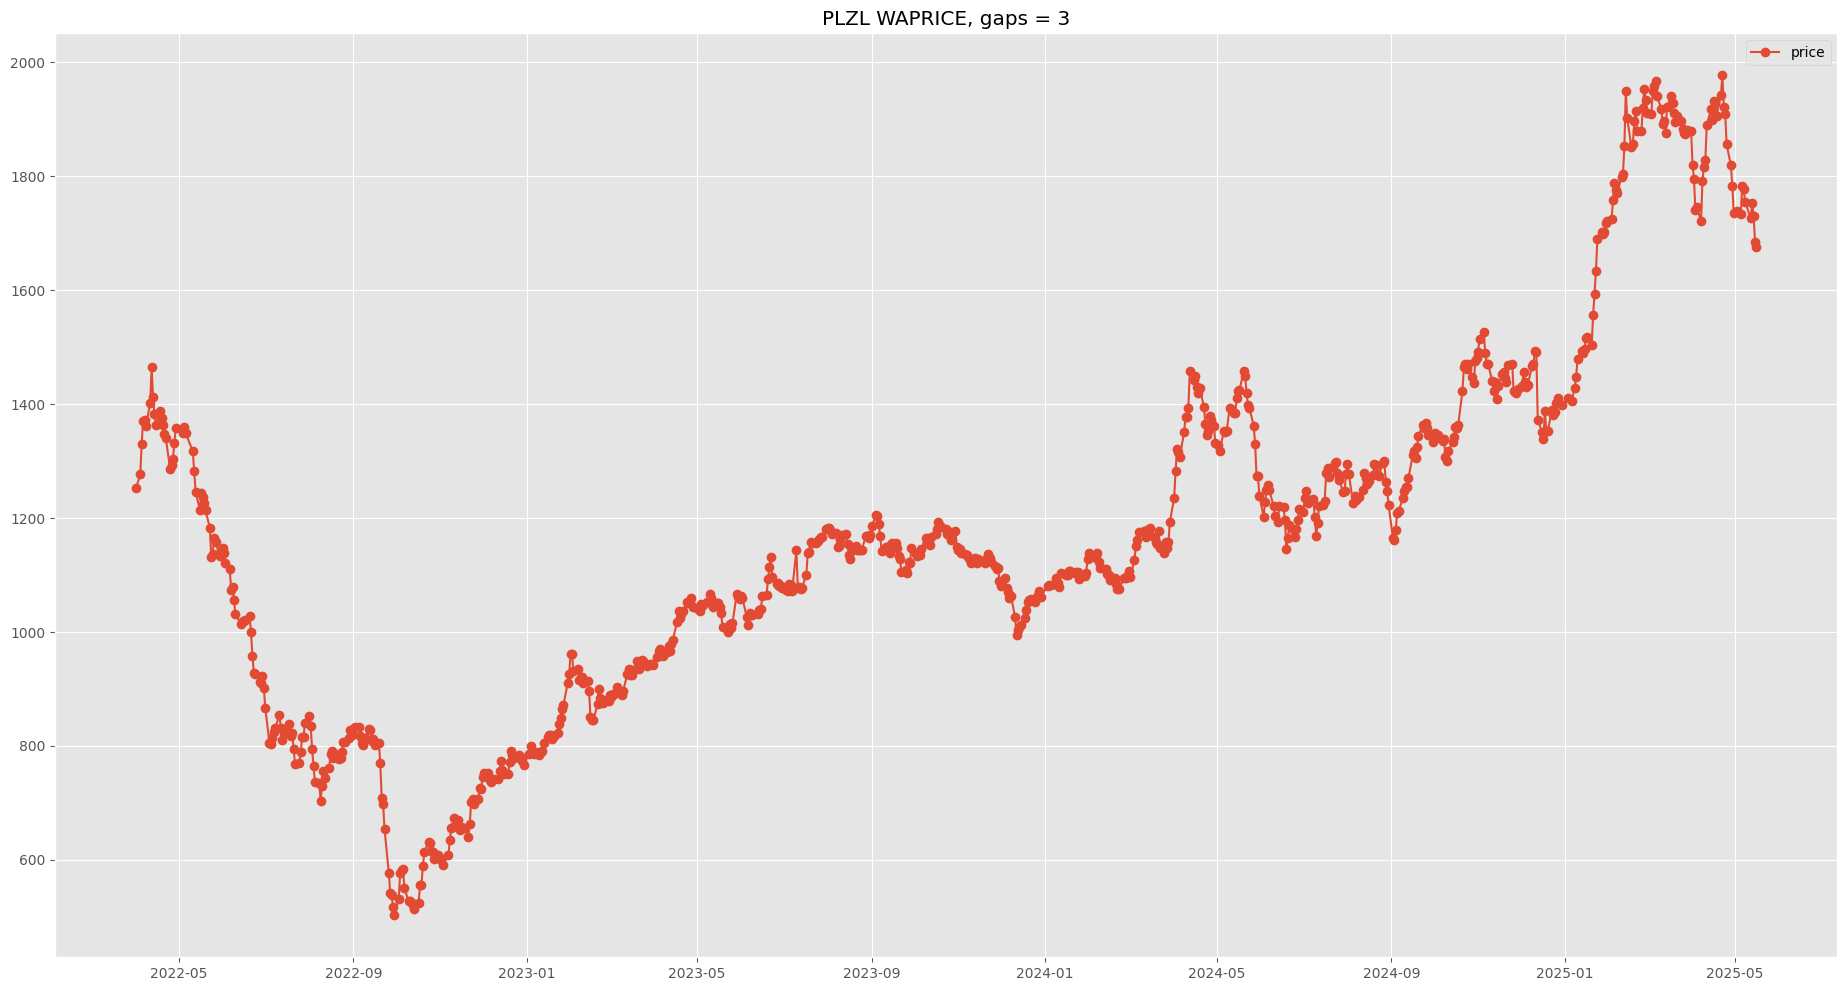

In [19]:
for ticker in list_of_tickers_with_gaps.index[list_of_tickers_with_gaps.values > 0]:
    plt.figure(figsize=(23, 12))

    plt.title(f'{ticker} WAPRICE, gaps = {list_of_tickers_with_gaps[ticker]}')

    plt.plot(df[df['SECID'] == ticker]['WAPRICE'], 
             marker='o',
             label='price')

    plt.legend()

In [20]:
df.isna().sum()

SECID      0
WAPRICE    0
OPEN       0
CLOSE      0
LOW        0
HIGH       0
VOLUME     0
dtype: int64

Пропусков больше нет

### Итоговый файл

In [21]:
df.to_csv('data_after_preprocessing.csv')